In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
plt.rcParams['figure.figsize'] = (24, 16)
import math
import os
from datetime import datetime

### Functions

In [3]:
def process_food_file(df):
    
    """
    This loads in each food file for each unique subject and processes it.
    
    First I will join date and time into one column.
    Since I don't plan on using computer vision I will drop the picture column.
    
    Then I will fix mistakes in the data entry.
    Mainly in the columns:
        1. balance
        2. quality
        3. calories
    """
    # Only health subjects contain the date and time columns.
    
    try:
        join_date_time(df, "date", "time")
    except KeyError:
        pass
    
    df.drop(columns=["picture"],inplace=True)
    
    df.replace('No information', np.nan,inplace=True)
    
    if '8 Balance""' in df["balance"]:
        df.replace('8 Balance""', "Balance",inplace=True)
    
    if df["calories"].dtypes == object:
        find_correct_calorie_column(df)
        
def find_correct_calorie_column(df):
    
    for i, value in enumerate(df["calories"]):   
        if type(value) != float: # This should filter out all Null values
            try:
                df["calories"][i] = int(value)
            except ValueError:
                if value in ["Balance","Unbalance"]:
                    df["balance"][i] = value
                elif value in ['Good quality', 'Medium quality', 'Low quality']:
                    df["quality"][i] = value
                elif type(df["description"][i]) == float:
                    df["description"][i] = value
                df["calories"][i] = np.nan

In [4]:
def process_glucose_file(df):
    
    """
    This loads in each glucose file for each unique subject and processes it.
    
    First I will join date and time into one column.
    
    Then I will fix mistakes in the data entry in glucose column.
    """
    # Only health subjects contain the date and time columns.
    
    try:
        join_date_time(df, "date", "time")
    except KeyError:
        pass
    
    df.replace('No information', np.nan,inplace=True)
    
    if df["glucose"].dtypes == object:
        fix_glucose_column(df)
        
def fix_glucose_column(df):
    """
    I have come across errors in the data entry where a : is used instead of a .
    I will find the mistakes and convert to the right format.
    """
    for i, value in enumerate(df["glucose"]):   
        if type(value) != float: # This should filter out all Null values
            try:
                df["glucose"][i] = float(value)
            except ValueError:
                df["glucose"][i] = float(value.replace(':', "."))
    

In [5]:
def join_date_time(df, date_col, time_col):
    new_df = pd.to_datetime(df[date_col].astype(str) + ' ' +df[time_col].astype(str))
    df.insert(2, 'datetime', new_df)
    df.drop(columns=[date_col, time_col],inplace=True)    

In [6]:
def plot_subjects(df,colName, title, xlabel):   
    fontdict = {"fontsize":20}
    plt.barh(df.index, df[colName],)
    plt.title(title,fontdict)
    plt.ylabel('Subject ID',fontdict)
    plt.xlabel(xlabel,fontdict)
    plt.show()

In [7]:
def plot_boxplot(df, title):
    fontdict = {"fontsize":20}
    plt.title(title)
    plt.title(title,fontdict)
    plt.ylabel('Meal Type',fontdict)
    plt.xlabel("Glucose Level",fontdict)
    sns.boxplot(data=df, width = 0.5,orient="horizontal") 

In [8]:
def pick_top_subjects(calories, glucose, n):
    myDict = {}
    for i, key in enumerate(calories.index):
        myDict[key] = i
    for i, key in enumerate(glucose.index):
        myDict[key] += i
    return pd.DataFrame(
        index=myDict.keys(), 
        data=myDict.values(),
        columns=["Count"]).sort_values(by="Count",
        ascending=False).head(n)

In [9]:
def copy_files(diabetes, healthy, included_012_diabetes=True):
    top_path = "../data/D1NAMO/"
    output_path = "../data/processed_data/"
    
    try:
        os.mkdir(f"{output_path}")
        os.mkdir(f"{output_path}/diabetes_subset")
        os.mkdir(f"{output_path}/healthy_subset")
    except:
        pass
    
    for subject in diabetes.index:
        copy_file_function(subject,"diabetes_subset")
        
    for subject in healthy.index:
        copy_file_function(subject,"healthy_subset")
        
    if included_012_diabetes:
        copy_file_function("012_diabetes","healthy_subset")
        
def copy_file_function(subject,subject_type):
    # Copy the glucose file
    top_path = "../data/D1NAMO/"
    output_path = "../data/processed_data/"
    src = f"{top_path}{subject_type}/{subject}/"
    dst = f"{output_path}{subject_type}/{subject}/"
    try:
        os.mkdir(dst)
        os.mkdir(f"{dst}sensor_data/")
    except:
        pass
    
    
    shutil.copy(f"{src}glucose.csv", f"{dst}glucose.csv")
    for day in os.listdir(f"{src}sensor_data"):
        if day != ".DS_Store":
            try:
                try:
                    os.mkdir(f"{dst}sensor_data/{day}/")
                except:
                    pass
                shutil.copy(f"{src}sensor_data/{day}/{day+'_Summary.csv'}", f"{dst}sensor_data/{day}/{day+'_Summary.csv'}")
            except FileNotFoundError:
                print(f"No such file or directory: {src}sensor_data/{day}/{day+'_Summary.csv'}")

In [10]:
def time_in_minutes(time):
    time = pd.to_datetime(time)
    
    hours = time.hour
    minutes = time.minute 
    
    return (hours * 60) + minutes

def minutes2time(minutes):
    hour = int(minutes // 60)
    minute = round(minutes % 60)
    return str(datetime.strptime(f"{hour}:{minute}", "%H:%M").time())

### Data Overview

Two different subject groups:

1. Healthy Subjects  
    This contains 20 subjects (1 with diabetes but treated to the same conditions as the healthy subjects)
2. Diabetes Subjects  
    This contains 9 subjects.

Data is collected over a 4 day period.

For this section I will only look at the following datasets.

1. food.csv
2. glucose.csv
3. insulin.csv (diabete subset)
4. annnotations.csv (healthy subset)


### Healthy Subjects
Files to process  
**food.csv**:

1. Join the *date* *and* time column as one.  
2. Remove the *pictureI*D column since there isn't enough annotated pictures to do anything interesting with.

**glucose.csv**

1. Join the *date* and *time* column as one. 
2. Remove the *comments* column since most subjects didn't make a comment.
3. Convert the *type* column to a numeric value.  
    1. This column represents when a subject measured their glucose level. e.g. BL = before lunch, AB = after breakfast
    
**annotations.csv**

This file was intended to contain extra data about the subjects daily activities, such as exercise but much subjects left blank. For this reason I will ignore this file

### Diabetes Subjects
Files to process  
**food.csv**:

1. Unlike the other subjects this did not contain a date or time column.
2. Remove the *pictureI*D column since there isn't enough annotated pictures to do anything interesting with.

It is clear that some subjects didn't include as much data as others.

**glucose.csv**

1. Join the *date* and *time* column as one. 
2. Remove the *comments* column since most subjects didn't make a comment.
3. *Type* is the method the glucose was measured, cgm automatically measured every 5 minutes while manual was randomly done by the subject. Some subjects manually checked less frequently.

    
    
**insulin.csv**

1. Join the *date* and *time* column as one. 
2. Unclear what fast and slow insulin means. Could investigate further.

### Simple data analysis

In this section I will explore various aspects of the files:

1. food.csv
2. glucose.csv
3. insulin.csv (diabete subset)
4. annnotations.csv (healthy subset)

In [11]:
top_path = "../data/D1NAMO/"

In [12]:
all_dfs = {}
for subject_ID in os.listdir(top_path+"healthy_subset/"):
    df = pd.read_csv(top_path+"healthy_subset/"+subject_ID+"/glucose.csv")
    df["time2minutes"] = df["time"].apply(lambda x: time_in_minutes(x))
    all_dfs[subject_ID] = df

In [13]:
average_mealtime = pd.DataFrame(index=['AB', 'AD', 'AL', 'BB', 'BD', 'BL'])
average_mealtime["average_time"] = 0
number_of_subjects = len(all_dfs.keys())
for key in all_dfs:
    average_mealtime["average_time"] = average_mealtime["average_time"] + (all_dfs[key].groupby("type").mean()["time2minutes"] / 20).values
average_mealtime["time"] = average_mealtime["average_time"].apply(lambda x : minutes2time(x))
average_mealtime.drop(columns=["average_time"],inplace=True)

C:\Users\PC\AppData\Local\Temp\ipykernel_5388\971506848.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_mealtime["average_time"] = average_mealtime["average_time"] + (all_dfs[key].groupby("type").mean()["time2minutes"] / 20).values
C:\Users\PC\AppData\Local\Temp\ipykernel_5388\971506848.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_mealtime["average_time"] = average_mealtime["average_time"] + (all_dfs[key].groupby("type").mean()["time2minutes"] / 20).values
C:\Users\PC\AppData\Local\Temp\ipykernel_5388\971506848.py:5: FutureWarning: The default value of numeric_only in DataFrameGro

In [15]:
average_mealtime

,time
AB,10:25:00
AD,20:17:00
AL,14:46:00
BB,08:06:00
BD,19:52:00
BL,12:18:00


In [14]:
# For the food.csv I will check if there are any incorrected values in the balance and quality columns
unique_balance = set()
unique_quality = set()
for subject_type in os.listdir(top_path):
    for subject_ID in os.listdir(top_path+subject_type):
        df = pd.read_csv(top_path+subject_type+"/"+subject_ID+"/food.csv")
        unique_balance = unique_balance.union(set(df["balance"]))
        unique_quality = unique_quality.union(set(df["quality"]))
print(unique_balance)
print(unique_quality)

# Some mistakes are '8 Balance' which I will convert to just 'Balance' and 'No information' I will impute as a null value.

{'Unbalance', nan, '8 Balance""', 'No information', 'Balance'}
{'Low quality', nan, 'No information', 'Good quality', 'Medium quality'}


In [16]:
"""
For the food.csv file I will look at the data type of each column and see if I see anything interesting
like a data type which doesn't belong in the coloumn.
"""


balance_dtypes = []
quality_dtypes = []
description_dtypes = []
calories_dtypes = []
for subject_type in os.listdir(top_path):
    for subject_ID in os.listdir(top_path+subject_type):
        df = pd.read_csv(top_path+subject_type+"/"+subject_ID+"/food.csv")
        balance_dtypes.append(df["balance"].dtype)
        quality_dtypes.append(df["quality"].dtype)
        description_dtypes.append(df["description"].dtype)
        calories_dtypes.append(df["calories"].dtype)
print(set(balance_dtypes))
print(set(quality_dtypes))
print(set(description_dtypes))
print(set(calories_dtypes))

"""
Calories should only be int or float so I believe this to be a mistake, 
I will check if this value belongs in another column.
"""


{dtype('O')}
{dtype('O')}
{dtype('O')}
{dtype('int64'), dtype('float64'), dtype('O')}


'\nCalories should only be int or float so I believe this to be a mistake, \nI will check if this value belongs in another column.\n'

In [28]:
for key in food_dfs:
    print(food_dfs[key].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  26 non-null     object
 1   calories     26 non-null     int64 
 2   balance      26 non-null     object
 3   quality      26 non-null     object
dtypes: int64(1), object(3)
memory usage: 960.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  8 non-null      object
 1   calories     8 non-null      int64 
 2   balance      8 non-null      object
 3   quality      8 non-null      object
dtypes: int64(1), object(3)
memory usage: 384.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0  

In [20]:
# I will collect calorie data from the food.csv file

calories_intake = {}
food_dfs = {}
for subject_type in os.listdir(top_path):
    calories_intake[subject_type] = {}
    for subject_ID in os.listdir(top_path+subject_type):
        df = pd.read_csv(top_path+subject_type+"/"+subject_ID+"/food.csv")
        process_food_file(df) # This function fixes some errors in the food.csv file.
        food_dfs[f"{subject_type[0]}_{subject_ID}"] = df
        calories_intake[subject_type][f"{subject_ID}"] = {"Total": df["calories"].sum(),
                                                          "Count": df["calories"].count(),
                                                           "Len": len(df["calories"])
                                                          }


C:\Users\PC\AppData\Local\Temp\ipykernel_5388\405990217.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["calories"][i] = int(value)
C:\Users\PC\AppData\Local\Temp\ipykernel_5388\405990217.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["description"][i] = value
C:\Users\PC\AppData\Local\Temp\ipykernel_5388\405990217.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["calories"][i] = np.nan
C:\Users\PC\AppData\Local

In [18]:
# Split the dict into two dataframes, sorted by the number of entries made.

diabetes_calories = pd.DataFrame(calories_intake["diabetes_subset"]).T.sort_values(by="Len")

healthy_calories = pd.DataFrame(calories_intake["healthy_subset"]).T.sort_values(by="Len")

In [29]:
calories_intake

{'diabetes_subset': {'001': {'Total': 13492, 'Count': 26, 'Len': 26},
  '002': {'Total': 5106, 'Count': 8, 'Len': 8},
  '003': {'Total': 2134, 'Count': 3, 'Len': 3},
  '004': {'Total': 4258, 'Count': 8, 'Len': 8},
  '005': {'Total': 3859, 'Count': 9, 'Len': 9},
  '006': {'Total': 5128, 'Count': 7, 'Len': 7},
  '007': {'Total': 12578, 'Count': 23, 'Len': 23},
  '008': {'Total': 9704.0, 'Count': 18, 'Len': 20},
  '009': {'Total': 6959, 'Count': 11, 'Len': 11}},
 'healthy_subset': {'001': {'Total': 8935.0, 'Count': 13, 'Len': 19},
  '002': {'Total': 7405, 'Count': 11, 'Len': 29},
  '003': {'Total': 2687.0, 'Count': 10, 'Len': 11},
  '004': {'Total': 8145, 'Count': 16, 'Len': 25},
  '005': {'Total': 10654.0, 'Count': 11, 'Len': 14},
  '006': {'Total': 7609.0, 'Count': 11, 'Len': 21},
  '007': {'Total': 7060, 'Count': 15, 'Len': 22},
  '008': {'Total': 5153.0, 'Count': 9, 'Len': 16},
  '009': {'Total': 6991, 'Count': 13, 'Len': 13},
  '010': {'Total': 4952.0, 'Count': 12, 'Len': 15},
  '011

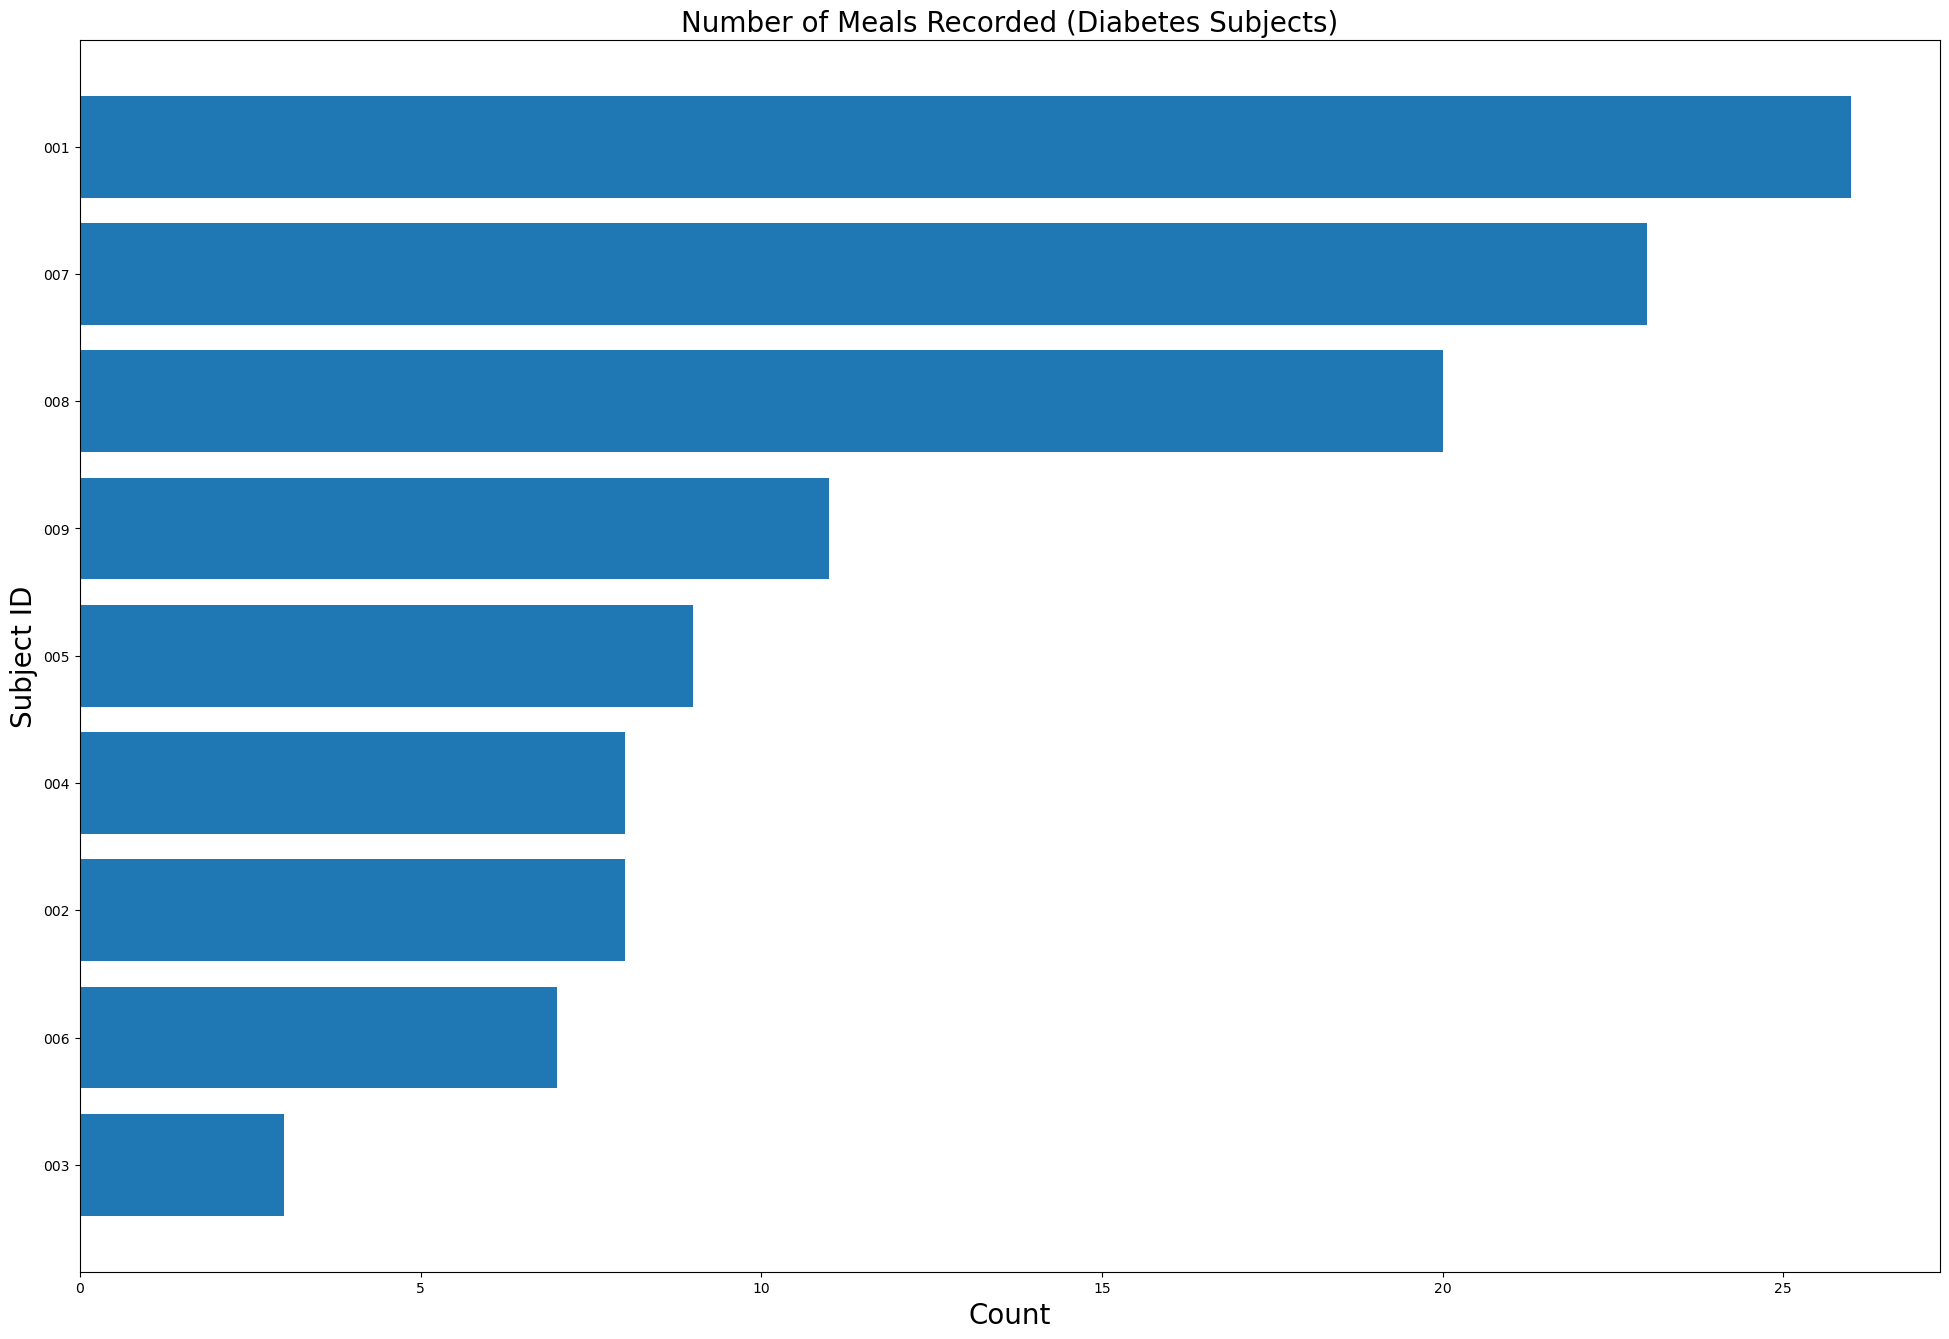

In [19]:
plot_subjects(diabetes_calories,"Len", "Number of Meals Recorded (Diabetes Subjects)", "Count")

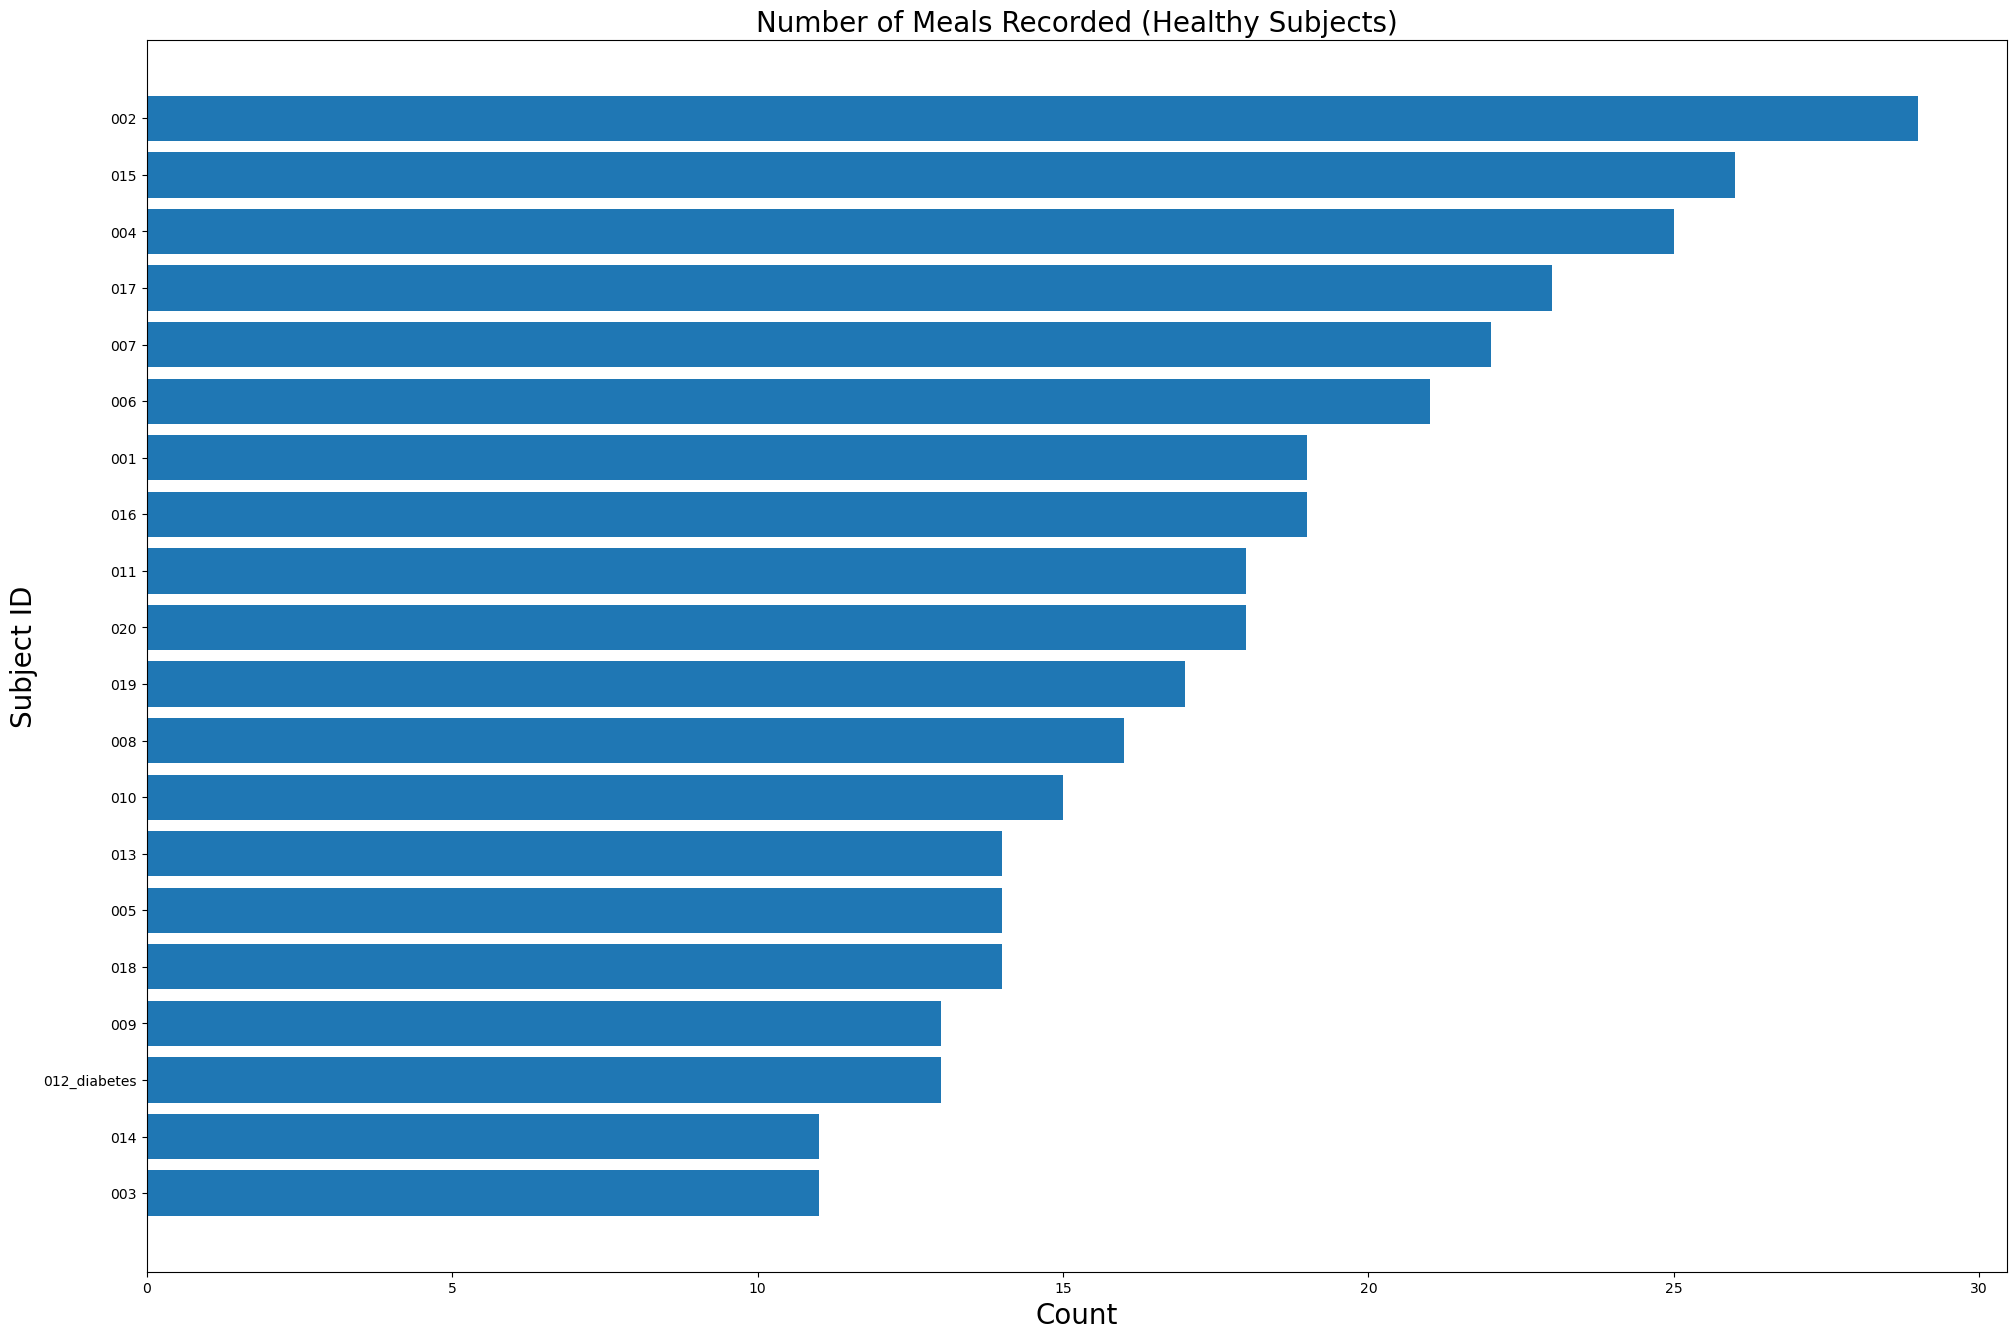

In [15]:
plot_subjects(healthy_calories,"Len", "Number of Meals Recorded (Healthy Subjects)", "Count")

#### Insights from the graphs

I can quickly see that some subjects were more thorough and inputed more data in comparison to others.  

Diabetes Subject 003 only included 3 meals over a 4 day period. While subject 001 included 25+ meals.  
For this reason I blieve that it will be difficult to use the food.csv file to complete further more complex analysis.



In [74]:
full_data["d_002"]

0       4.6
1       4.4
2       4.0
3       4.2
4       3.6
       ... 
1066    4.6
1067    4.6
1068    4.6
1069    4.5
1070    3.2
Name: glucose, Length: 1071, dtype: float64

In [127]:
glucose_df = pd.DataFrame()
if len(glucose_df.index) == 0:
    glucose_df.index = df["datetime"].values
rename_dict = {"glucose":f"d_001"}
glucose_df = glucose_df.join(df.set_index("datetime")[["glucose"]].rename(columns=rename_dict), how="outer") 

In [301]:
# I will collect glucose data from the glucose.csv file
indexNames = ["AB", "AD", "AL", "BB", "BD", "BL"]
meals_df = pd.DataFrame(index=indexNames)
glucose_levels = {}
glucose_data = {}
full_data = {}
glucose_df = pd.DataFrame()
for subject_type in os.listdir(top_path):
    glucose_levels[subject_type] = {}
    glucose_data[subject_type] = {}
    for subject_ID in os.listdir(top_path+subject_type):
        
        df = pd.read_csv(top_path+subject_type+"/"+subject_ID+"/glucose.csv")
        process_glucose_file(df) # This function fixes some errors in the glucose.csv file.
        
        glucose_levels[subject_type][f"{subject_ID}"] = {
        "Mean": df["glucose"].mean(),
        "Count": df["glucose"].count() if subject_type == "healthy_subset" else df[df["type"] == "manual"]["glucose"].count(),
        "STD": np.std(df["glucose"])
                                                          }
        if subject_type == "healthy_subset":
            meals_df = meals_df.join(df.groupby("type").mean()[["glucose"]].rename(columns={"glucose":f"{subject_ID}"}))
        
        glucose_data[subject_type][f"{subject_ID}"] = df["glucose"]
        full_data[f"{subject_type[0]}_{subject_ID}"] = df["glucose"]
        
        if len(glucose_df.index) == 0:
            glucose_df.index = df["datetime"].values
        rename_dict = {"glucose":f"{subject_type[0]}_{subject_ID}"}
        glucose_df = glucose_df.join(df.set_index("datetime")[["glucose"]].rename(columns=rename_dict), how="outer") 

C:\Users\PC\AppData\Local\Temp\ipykernel_20144\1575068736.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  meals_df = meals_df.join(df.groupby("type").mean()[["glucose"]].rename(columns={"glucose":f"{subject_ID}"}))
C:\Users\PC\AppData\Local\Temp\ipykernel_20144\1575068736.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  meals_df = meals_df.join(df.groupby("type").mean()[["glucose"]].rename(columns={"glucose":f"{subject_ID}"}))
C:\Users\PC\AppData\Local\Temp\ipykernel_20144\1575068736.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version,

KeyError: "None of [Index(['glucose'], dtype='object')] are in the [columns]"

In [314]:
average_mealtime

,time
AB,10:25:00
AD,20:17:00
AL,14:46:00
BB,08:06:00
BD,19:52:00
BL,12:18:00


C:\Users\PC\anaconda3\envs\CA4016\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


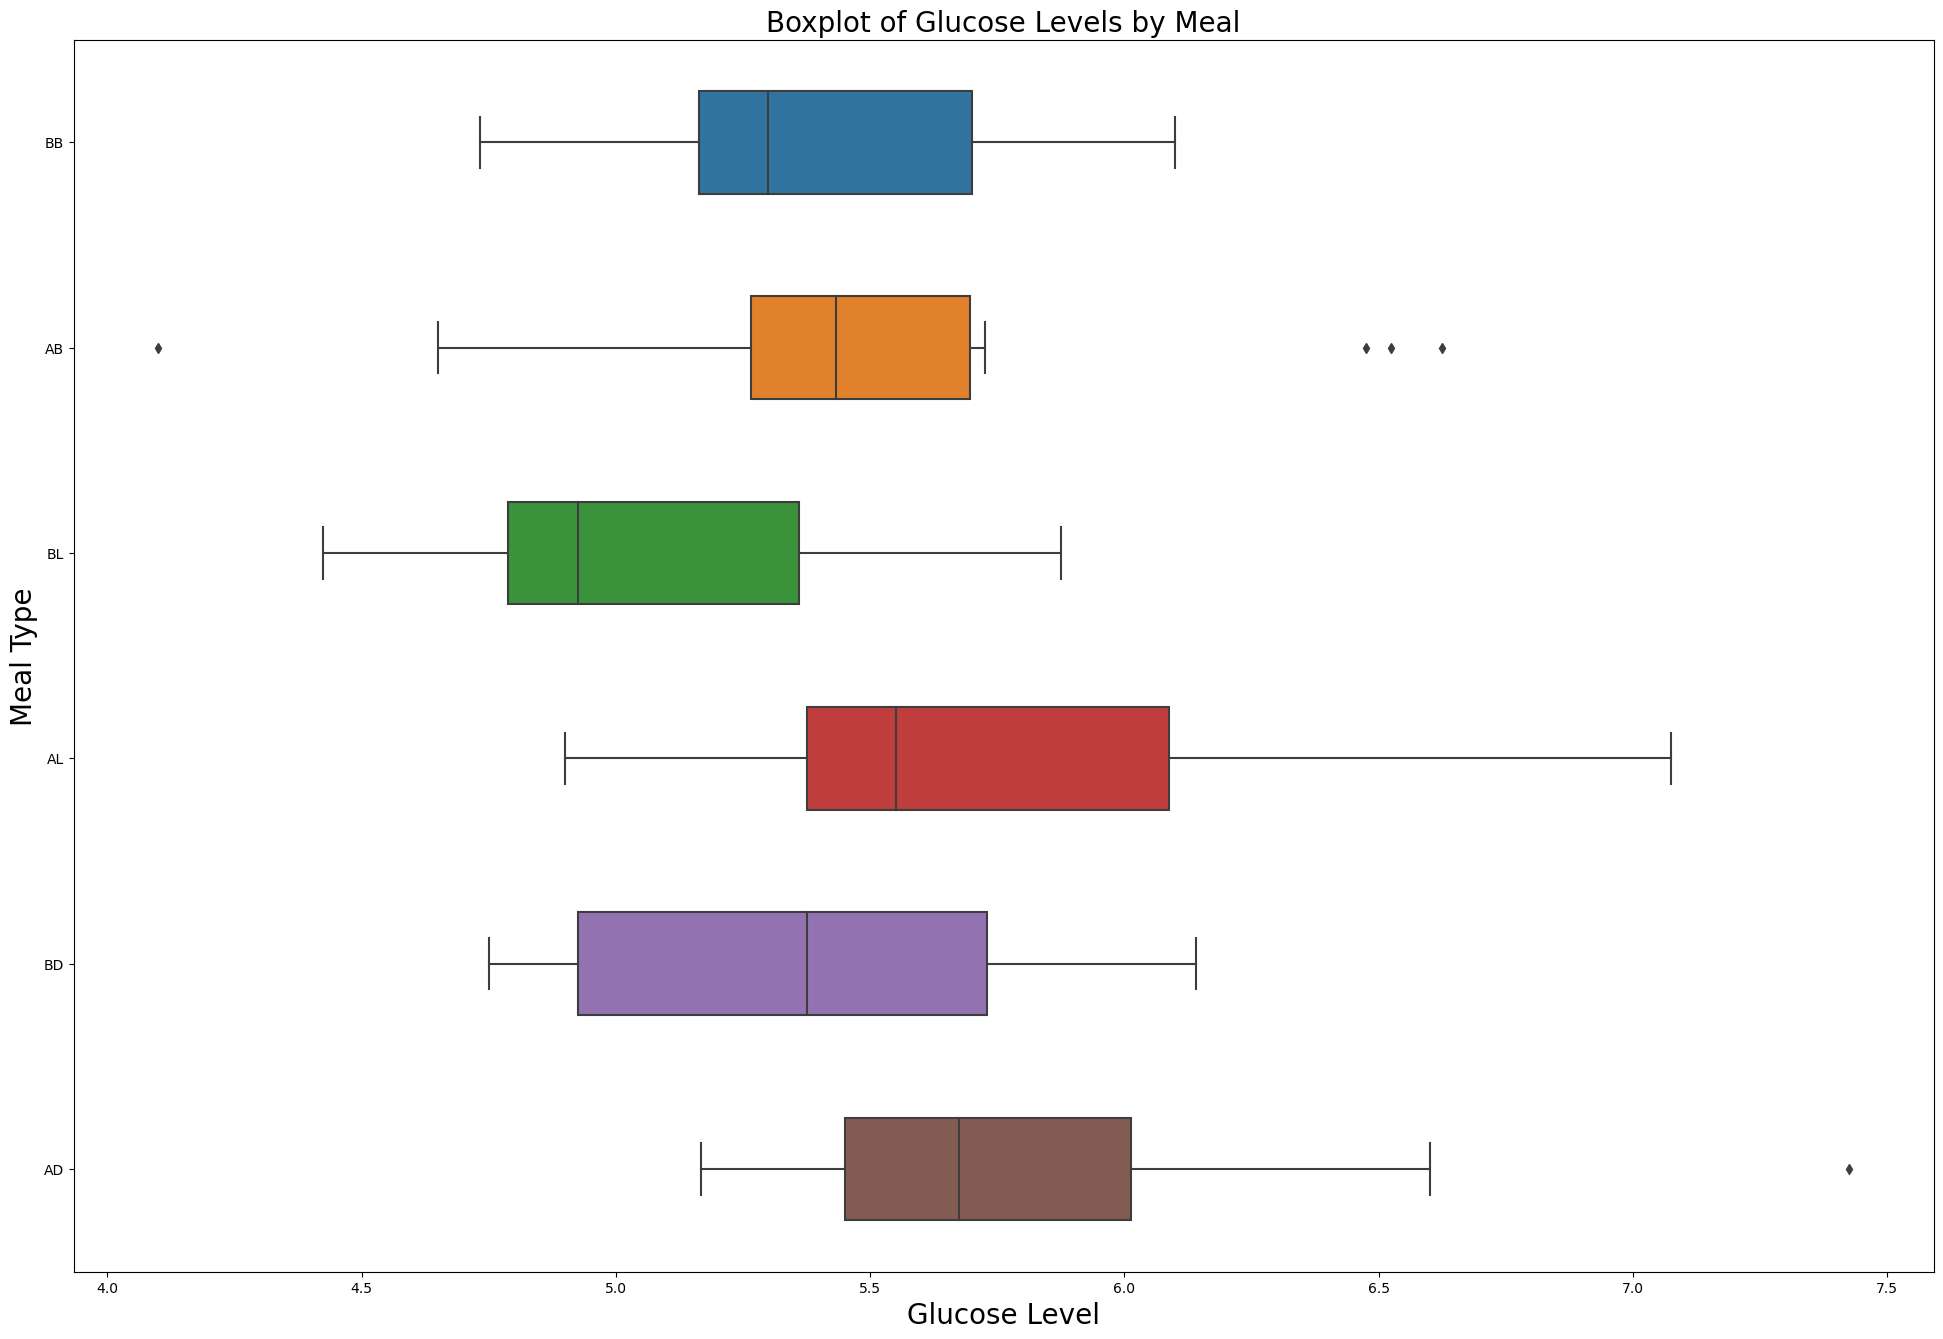

In [336]:
plot_boxplot(meals_df.join(average_mealtime).sort_values(by="time").drop(columns=["time","012_diabetes"]).T, "Boxplot of Glucose Levels by Meal")

C:\Users\PC\anaconda3\envs\CA4016\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot:>

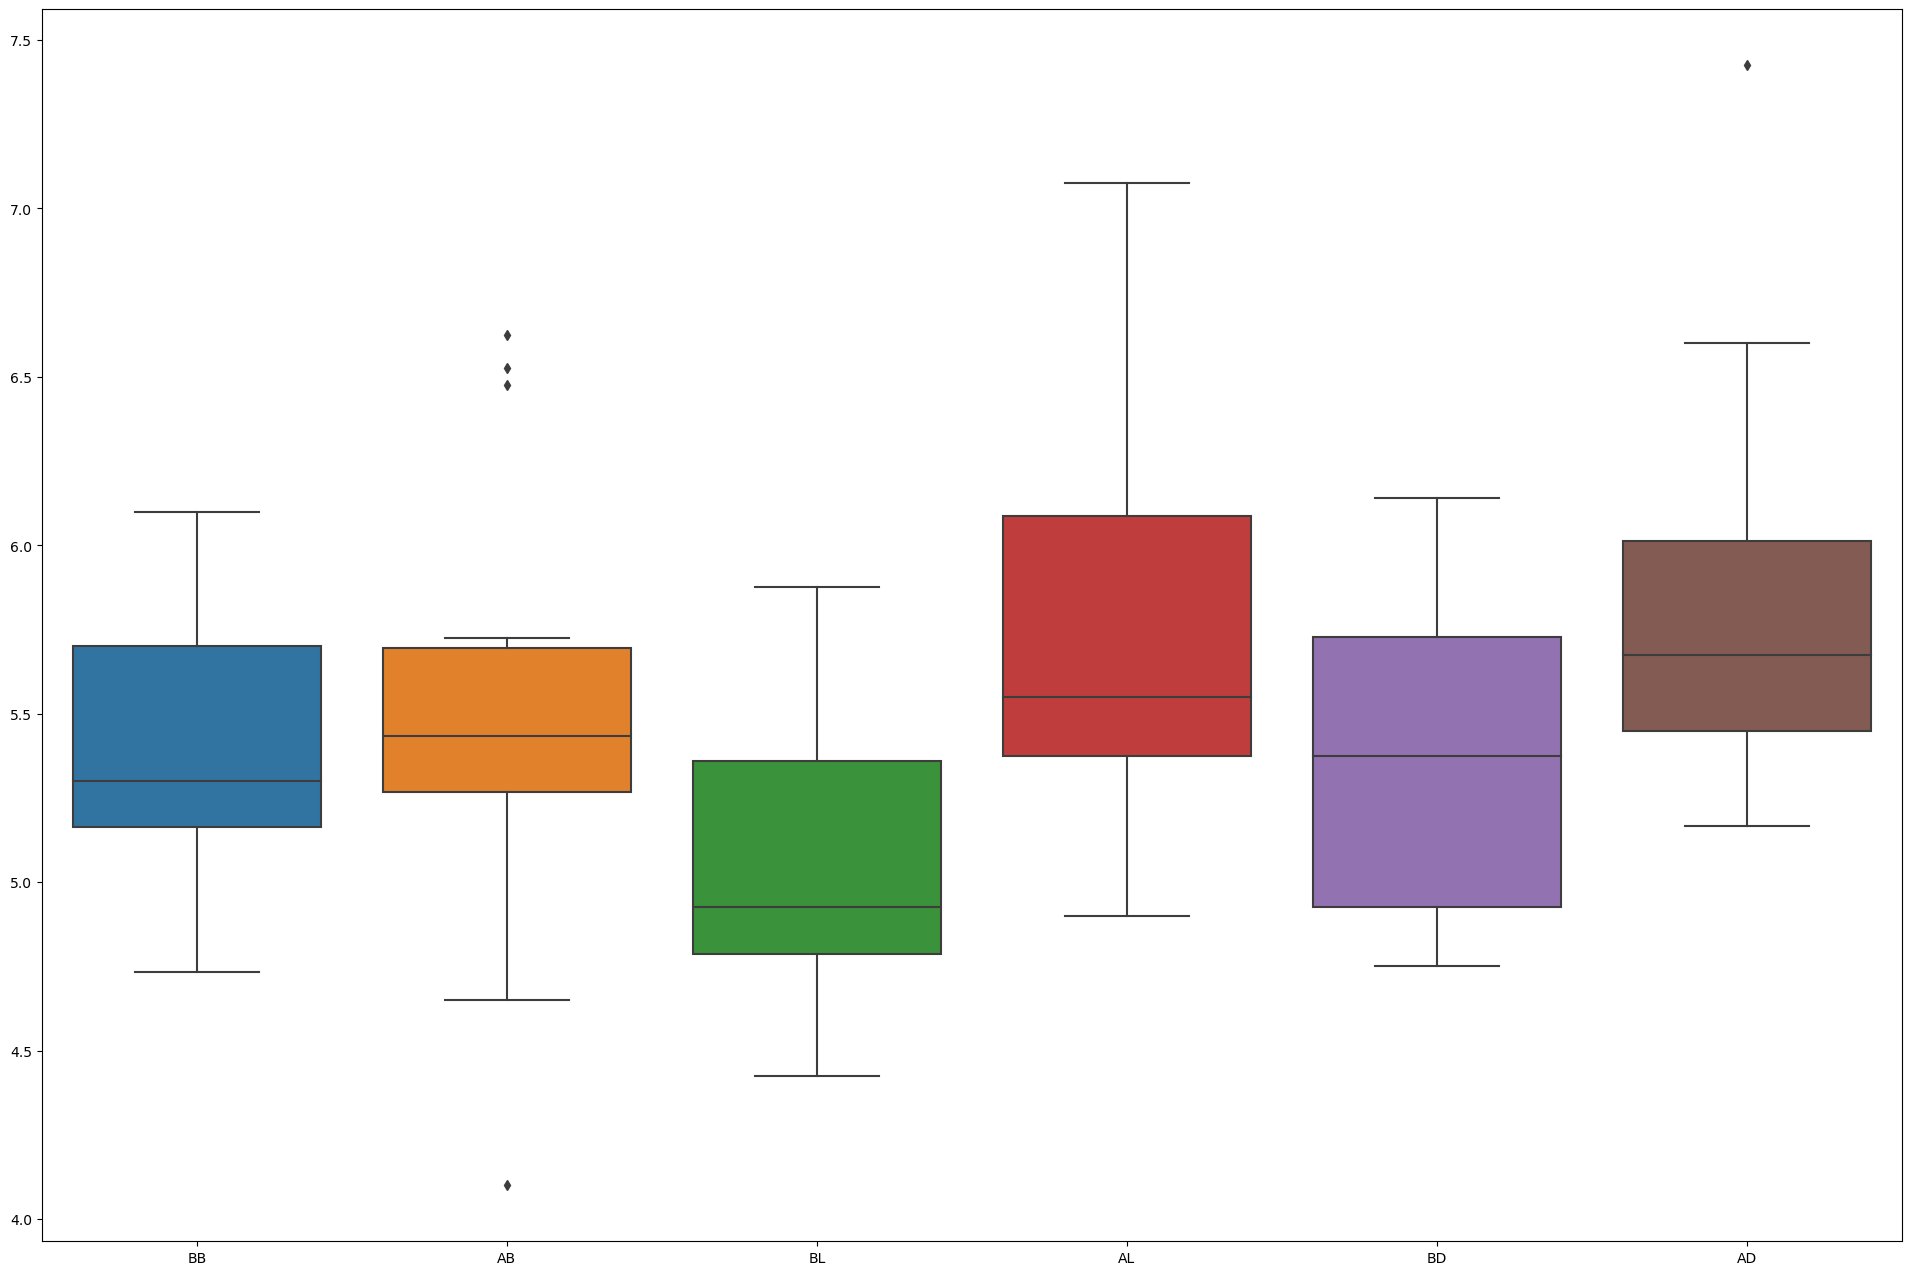

In [331]:
sns.boxplot()

C:\Users\PC\anaconda3\envs\CA4016\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot:>

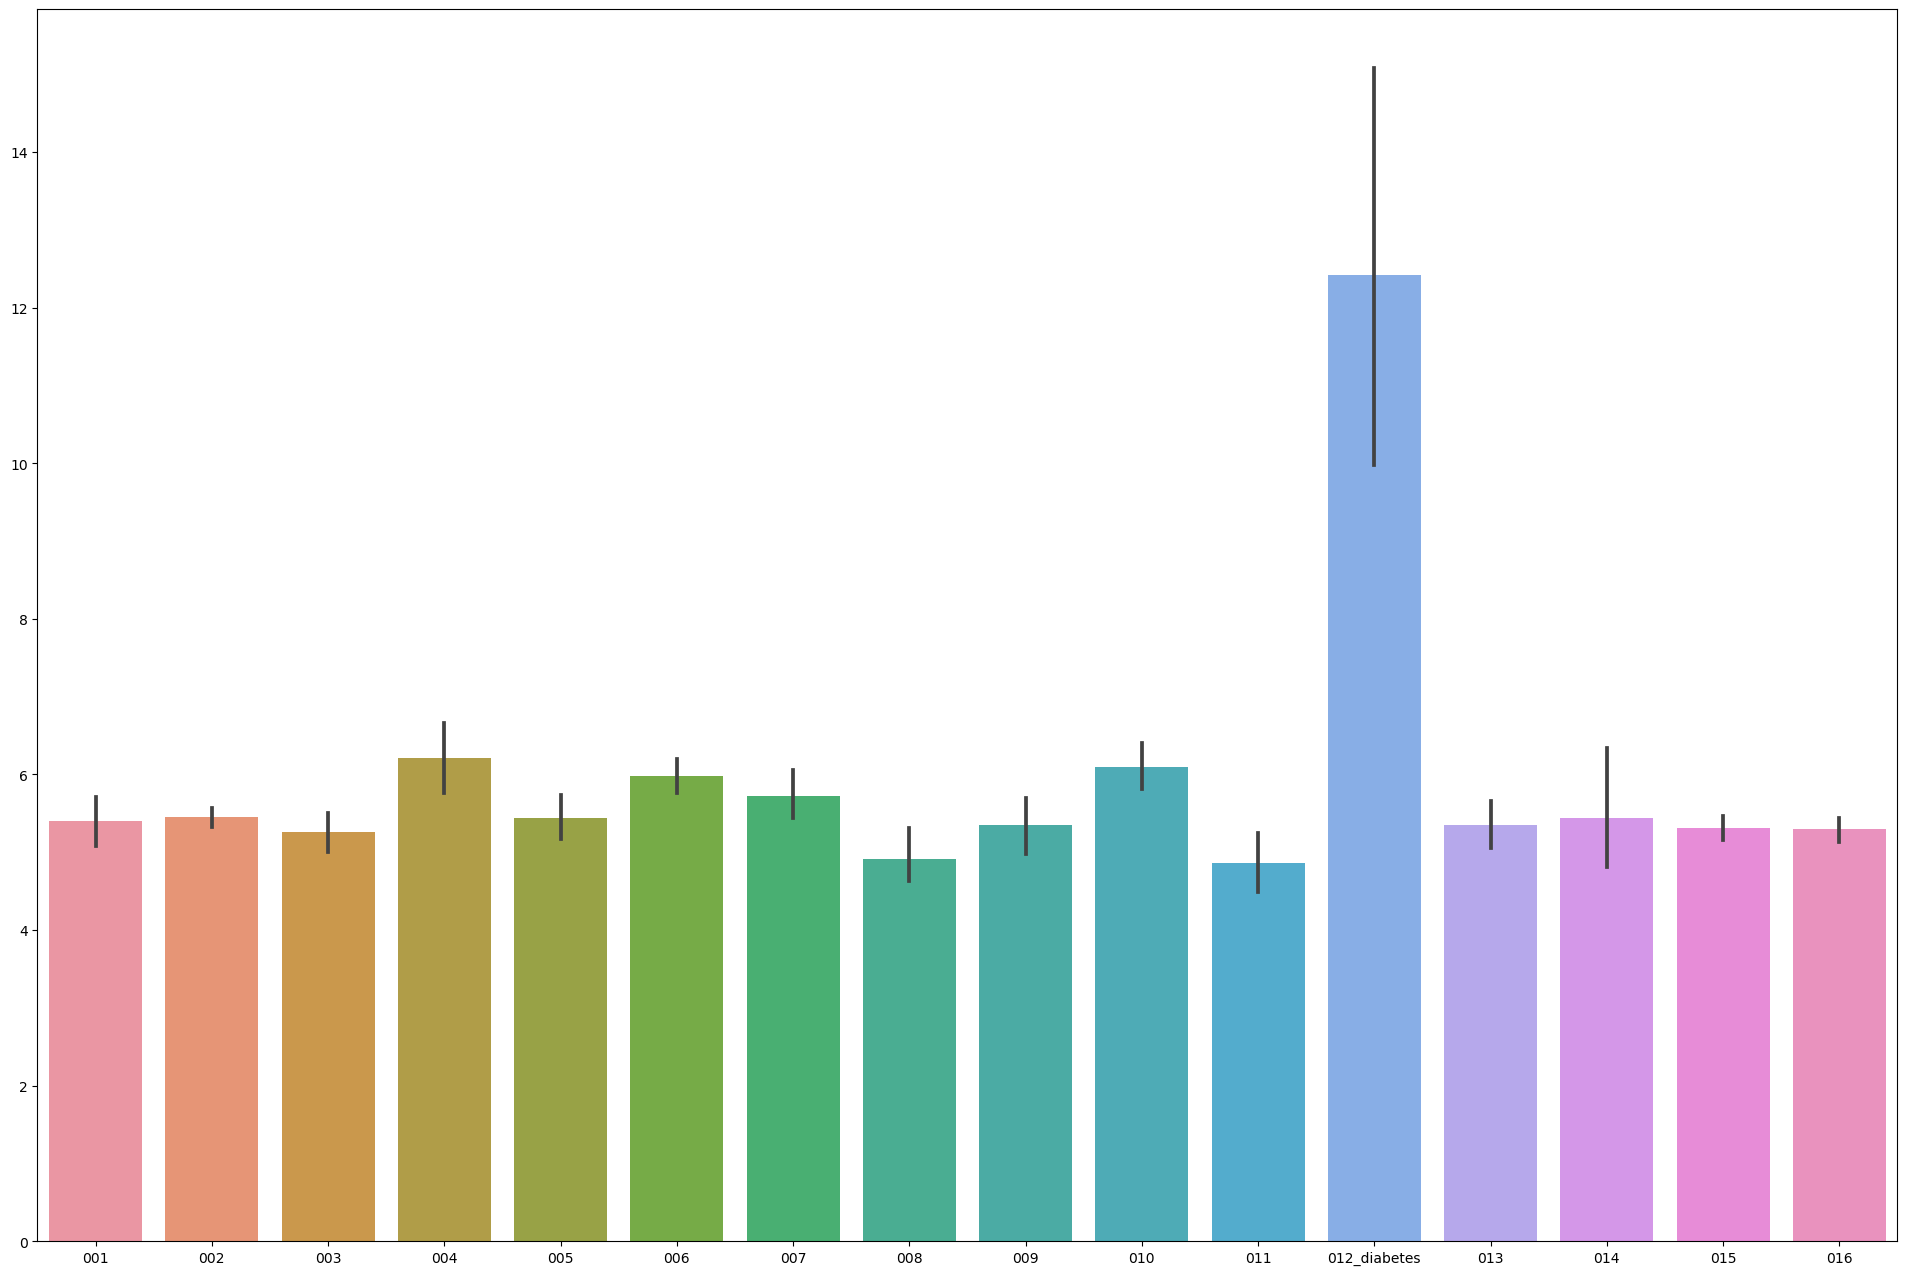

In [306]:
sns.barplot(meals_df)

In [168]:
glucose_df.reset_index()["index"].apply(lambda x: x.hour).values

array([ 8,  9,  9, ..., 16, 16, 16], dtype=int64)

In [169]:
glucose_df["hour"] = glucose_df.reset_index()["index"].apply(lambda x: x.hour).values

In [200]:
ddd = glucose_df.groupby("hour").mean()

C:\Users\PC\AppData\Local\Temp\ipykernel_20144\2458951029.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ddd = glucose_df.groupby("hour").mean()


In [290]:
ddd

,d_001,d_002,d_003,d_004,d_005,d_006,d_007,d_008,d_009,h_001,...,h_010,h_011,h_012_diabetes,h_013,h_014,h_015,h_016,h_018,h_019,h_020
hour,,,,,,,,,,,,,,,,,,,,,
0,13.443548,13.775000,8.200000,10.472222,8.830556,10.620000,8.672917,6.487500,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.20,NaN,NaN,NaN
1,12.016667,13.589583,NaN,12.080556,7.702778,9.541667,10.106250,6.686000,NaN,NaN,...,4.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.131667,13.108333,NaN,12.497222,7.959459,9.831148,10.385714,8.261224,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.436667,12.772917,NaN,11.744444,8.688889,10.233333,9.275556,8.095833,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.936667,12.331250,NaN,11.172222,8.522222,10.485000,8.663889,7.904167,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5.838333,11.479167,NaN,9.921622,7.891667,10.513333,8.583333,7.461224,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5.738095,10.072917,NaN,10.769444,6.933333,10.613333,8.497222,6.658824,5.769231,NaN,...,NaN,NaN,8.400000,NaN,NaN,NaN,NaN,NaN,5.000,4.800000
7,8.223333,10.698077,NaN,12.948649,6.226316,10.445902,8.655263,5.704167,3.853846,5.750000,...,NaN,4.800000,9.600000,NaN,NaN,NaN,NaN,5.400000,4.700,NaN
8,6.771667,8.229167,7.600000,12.231915,7.615789,10.790909,8.575676,5.376000,4.823810,5.800000,...,5.600000,5.100000,10.500000,5.300000,4.800000,5.233333,NaN,5.400000,6.200,6.166667


In [289]:
pd.read_csv("../data/D1NAMO/diabetes_subset/001/glucose.csv")

,date,time,glucose,type,comments
0,2014-10-01,19:14:00,10.3,cgm,NaN
1,2014-10-01,19:19:00,9.9,cgm,NaN
2,2014-10-01,19:23:00,9.4,manual,NaN
3,2014-10-01,19:24:00,9.8,cgm,NaN
4,2014-10-01,19:29:00,9.6,cgm,NaN
...,...,...,...,...,...
1433,2014-10-06,16:34:02,12.3,cgm,NaN
1434,2014-10-06,16:39:02,12.5,cgm,NaN
1435,2014-10-06,16:44:02,12.5,cgm,NaN
1436,2014-10-06,16:49:02,12.3,cgm,NaN


In [245]:
ddd.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64', name='hour')

In [246]:
for val in average_mealtime["time"]:
    print(int(val.split(":")[0]))

10
20
14
8
19
12


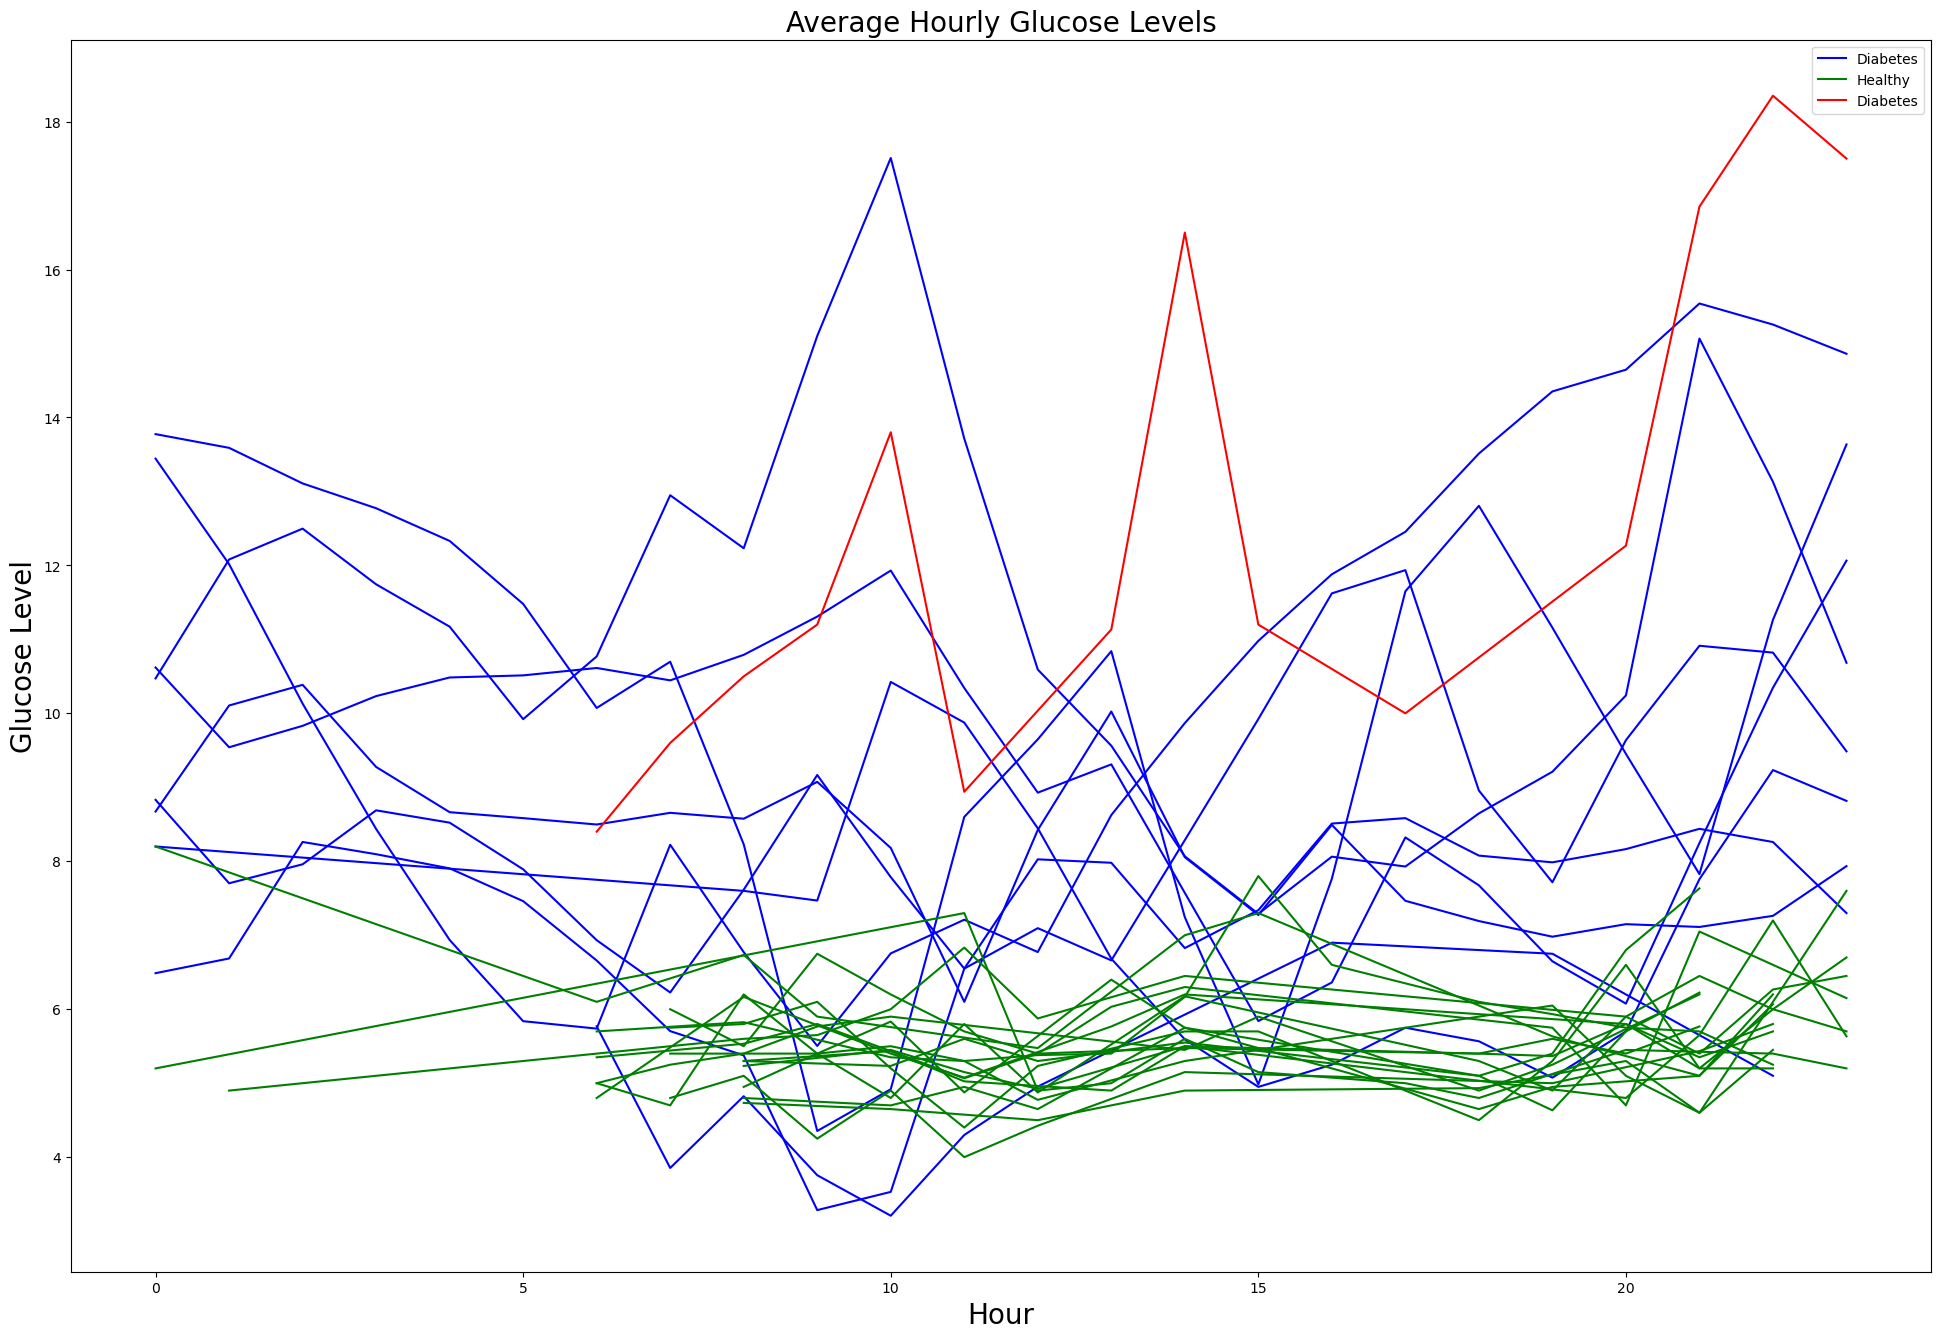

In [249]:
fontdict = {"fontsize":20}
plt.title("Average Hourly Glucose Levels",fontdict=fontdict)
d, dh, h = 0,0,0
for colName in ddd:
    if colName[0] == "d":
        if d == 0:
            sns.lineplot(ddd[colName],color="b",label="Diabetes")
            d += 1
        else:
            sns.lineplot(ddd[colName],color="b")
    elif len(colName) > 6:
        if dh == 0:
            sns.lineplot(ddd[colName],color="r", label="Diabetes") 
            dh += 1
        else:
            sns.lineplot(ddd[colName],color="r") 
    else:
        if h == 0:
            sns.lineplot(ddd[colName],color="g", label="Healthy") 
            h += 1
        else:
            sns.lineplot(ddd[colName],color="g")
plt.ylabel("Glucose Level",fontdict=fontdict)
plt.xlabel("Hour",fontdict=fontdict)
plt.show();

Text(0.5, 0, 'Hour')

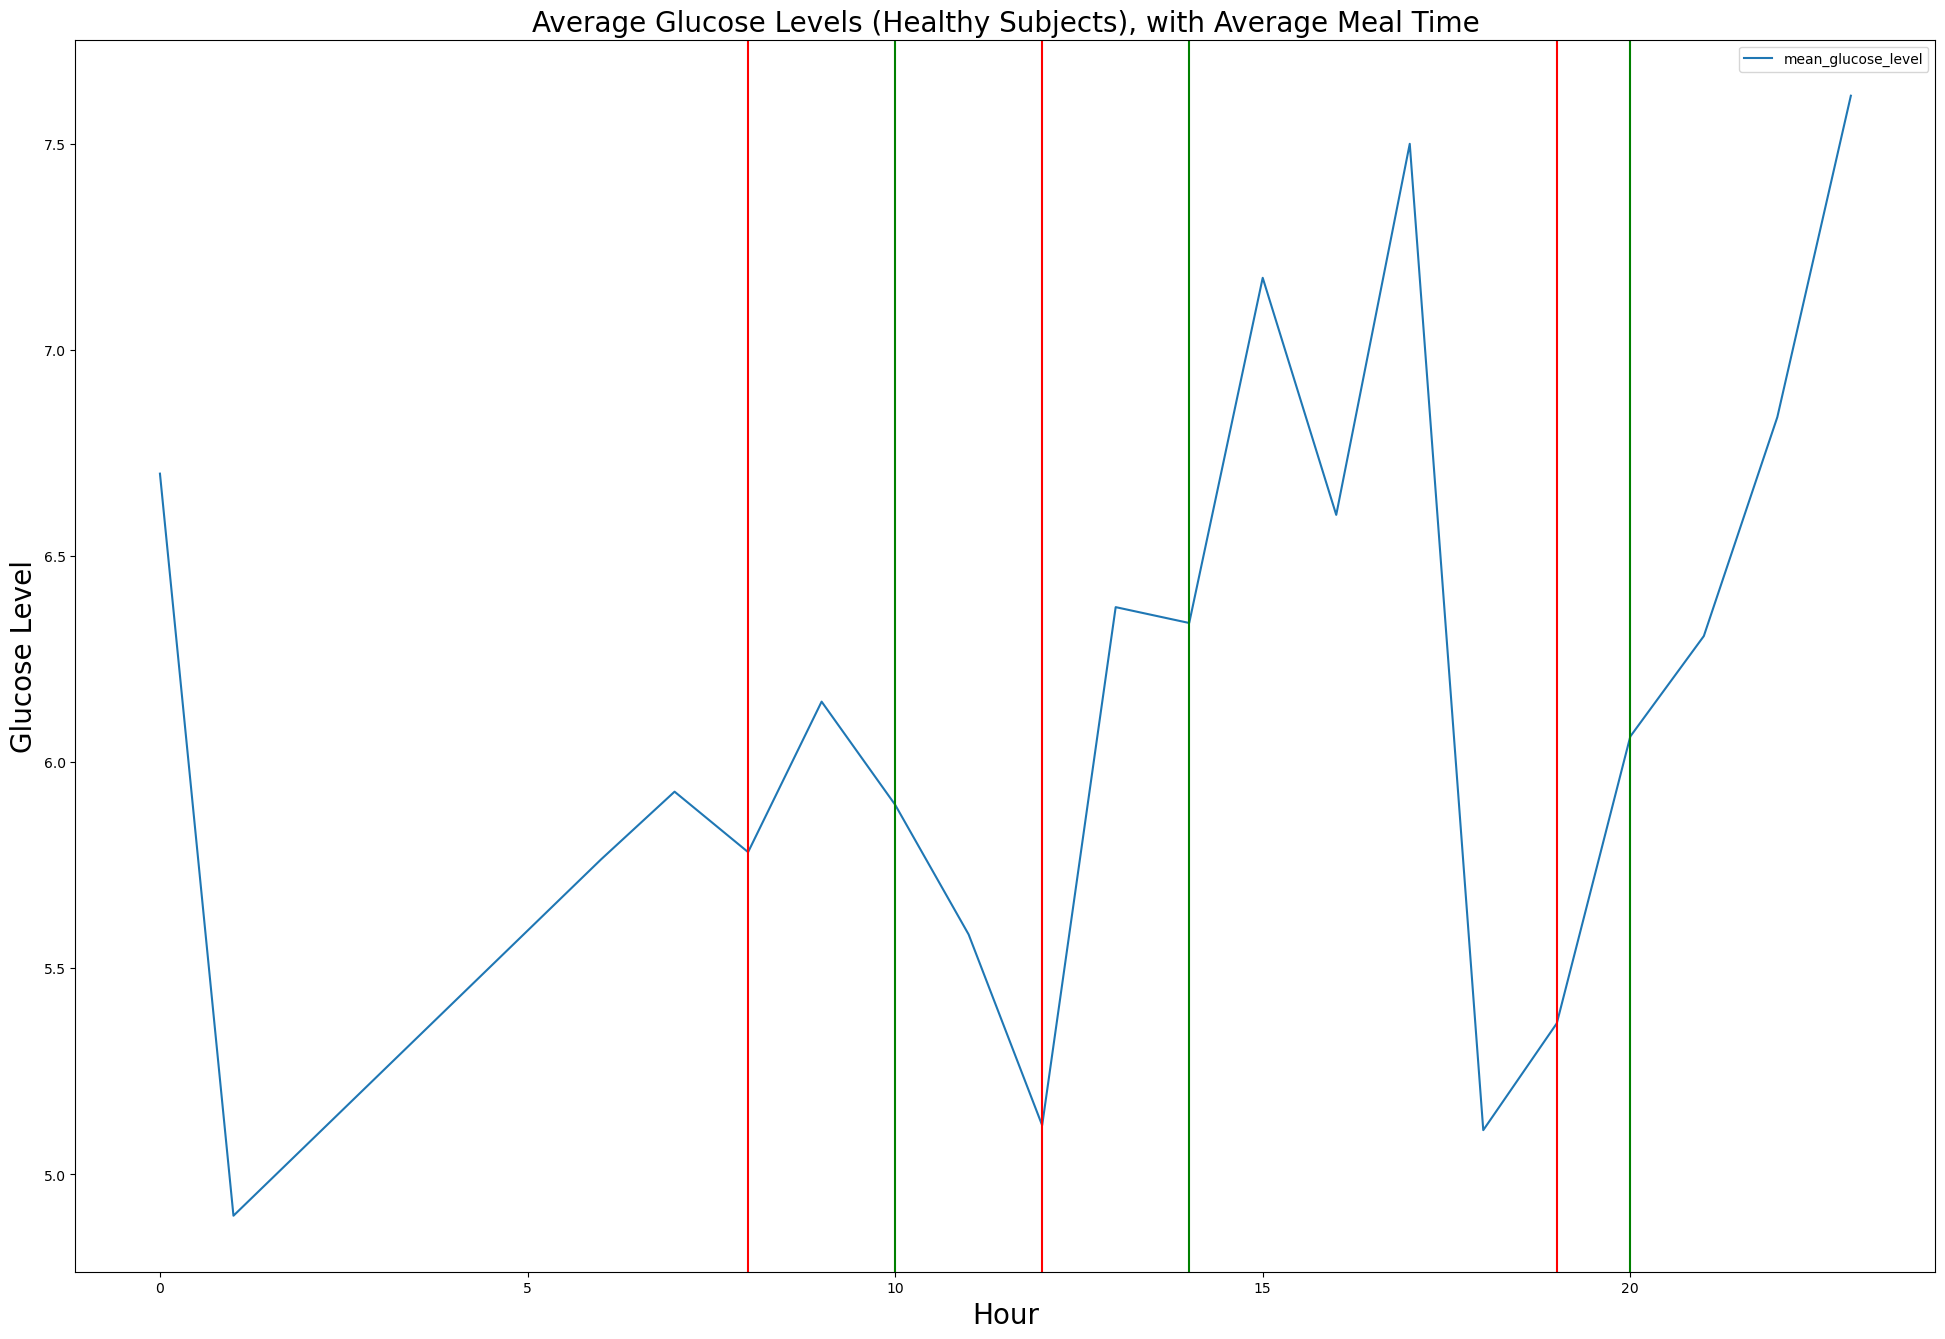

In [288]:
plt.title("Average Glucose Levels (Healthy Subjects), with Average Meal Time",fontdict=fontdict)
sns.lineplot(pd.DataFrame(ddd[[colName for colName in ddd.columns if colName[0]== "h"]].T.mean(),columns=["mean_glucose_level"]))
for i, val in enumerate(average_mealtime["time"]):
    if average_mealtime.index[i][0][0] == "A":
        plt.axvline(int(val.split(":")[0]), color="g")
    if average_mealtime.index[i][0][0] == "B":
        plt.axvline(int(val.split(":")[0]), color="r")
plt.ylabel("Glucose Level",fontdict=fontdict)
plt.xlabel("Hour",fontdict=fontdict)

In [282]:
average_mealtime.index[0][0] == "A"

True

In [17]:
# Split the dict into two dataframes, sorted by the number of entries made.
diabetes_glucose_count = pd.DataFrame(glucose_levels["diabetes_subset"]).T.sort_values(by="Count")

healthy_glucose_count = pd.DataFrame(glucose_levels["healthy_subset"]).T.sort_values(by="Count")

Since the diabetes subject have a device that automatically takes their glucose level, I will only look at manual measurements

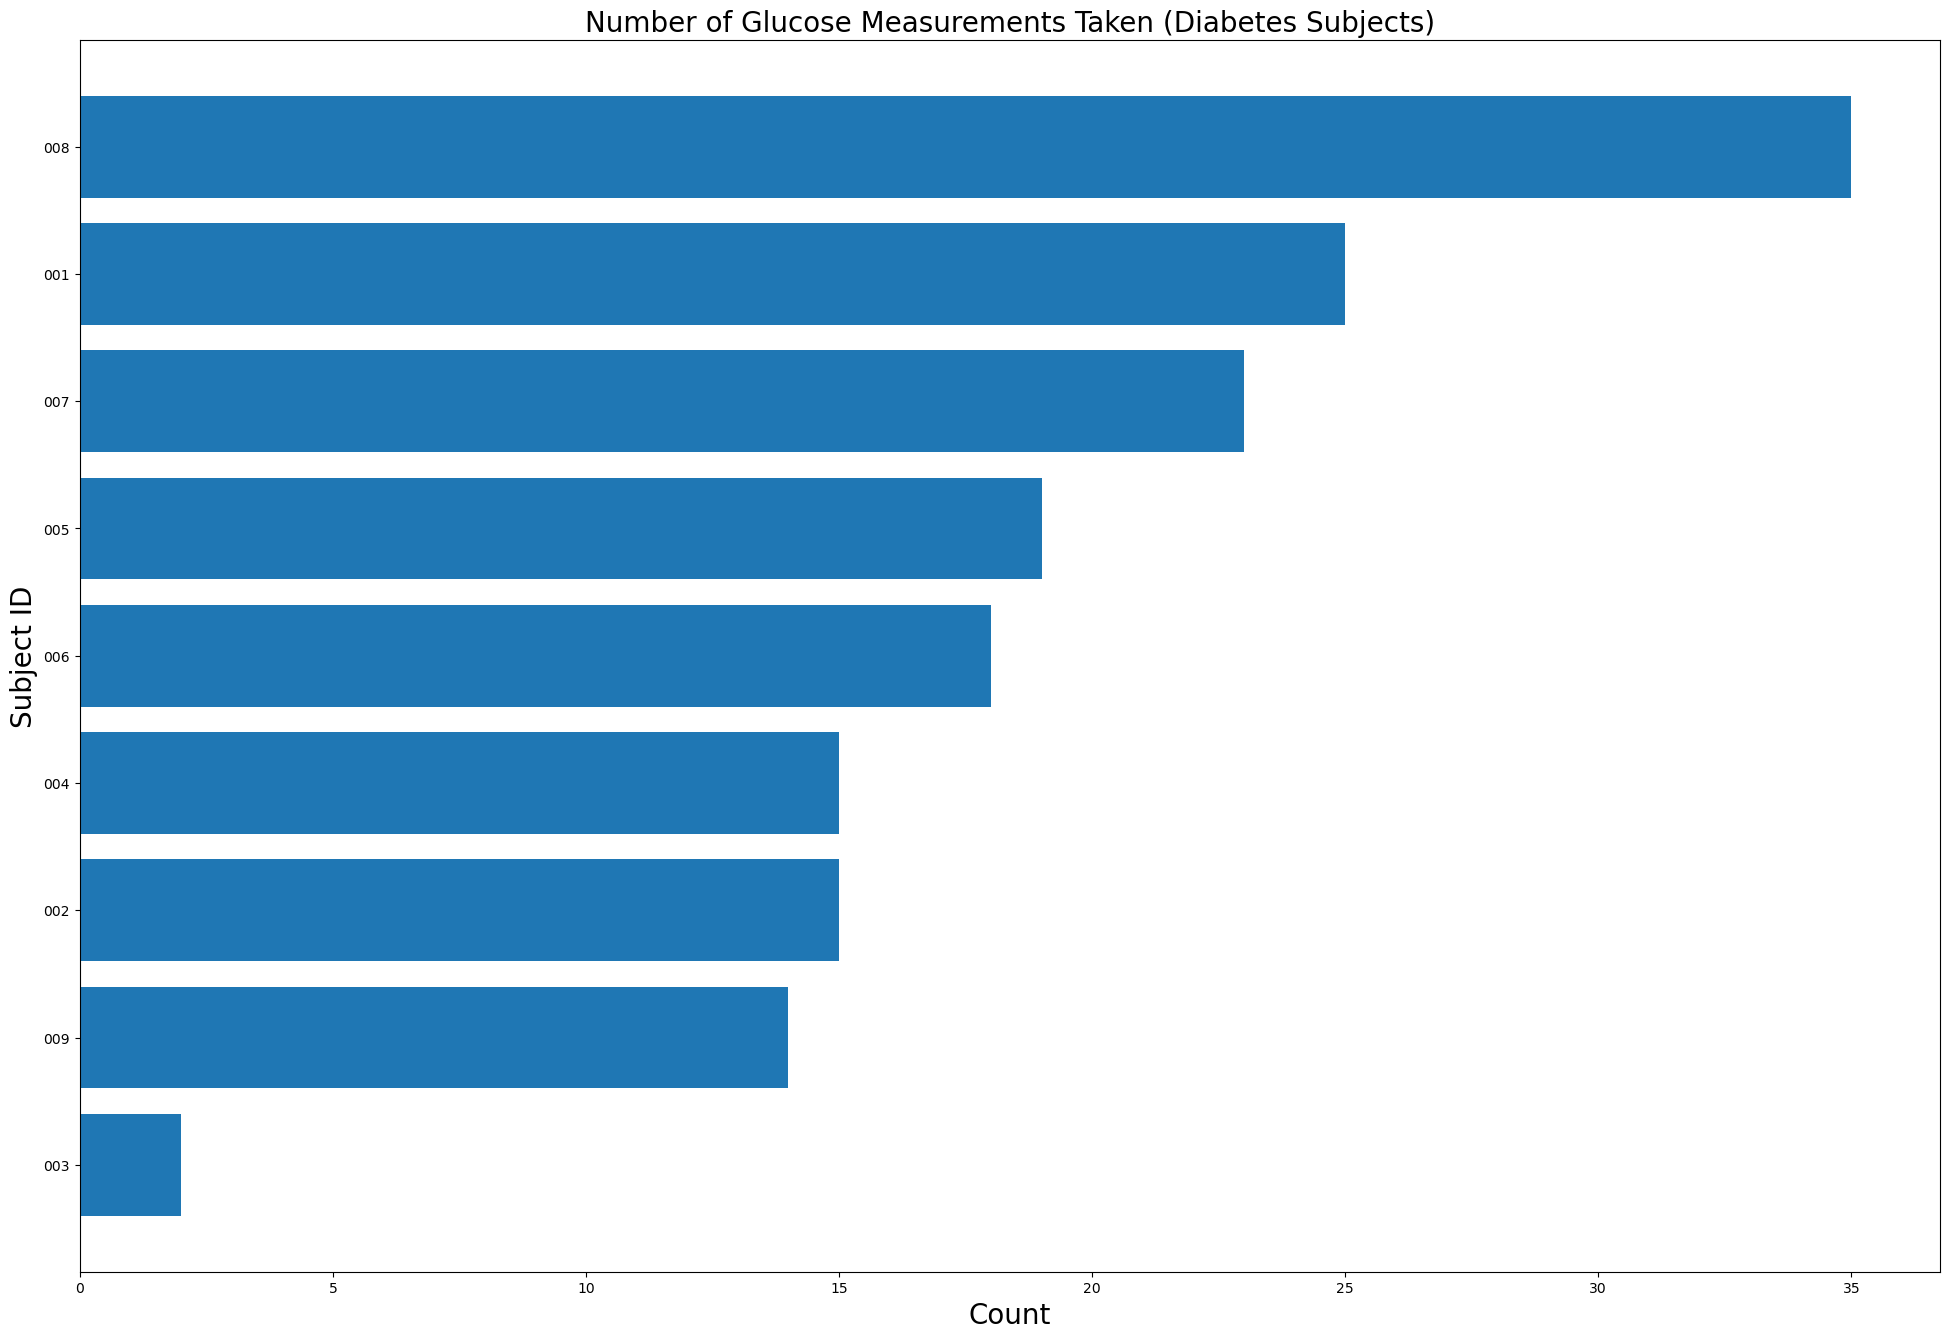

In [18]:
plot_subjects(diabetes_glucose_count,"Count", "Number of Glucose Measurements Taken (Diabetes Subjects)", "Count")

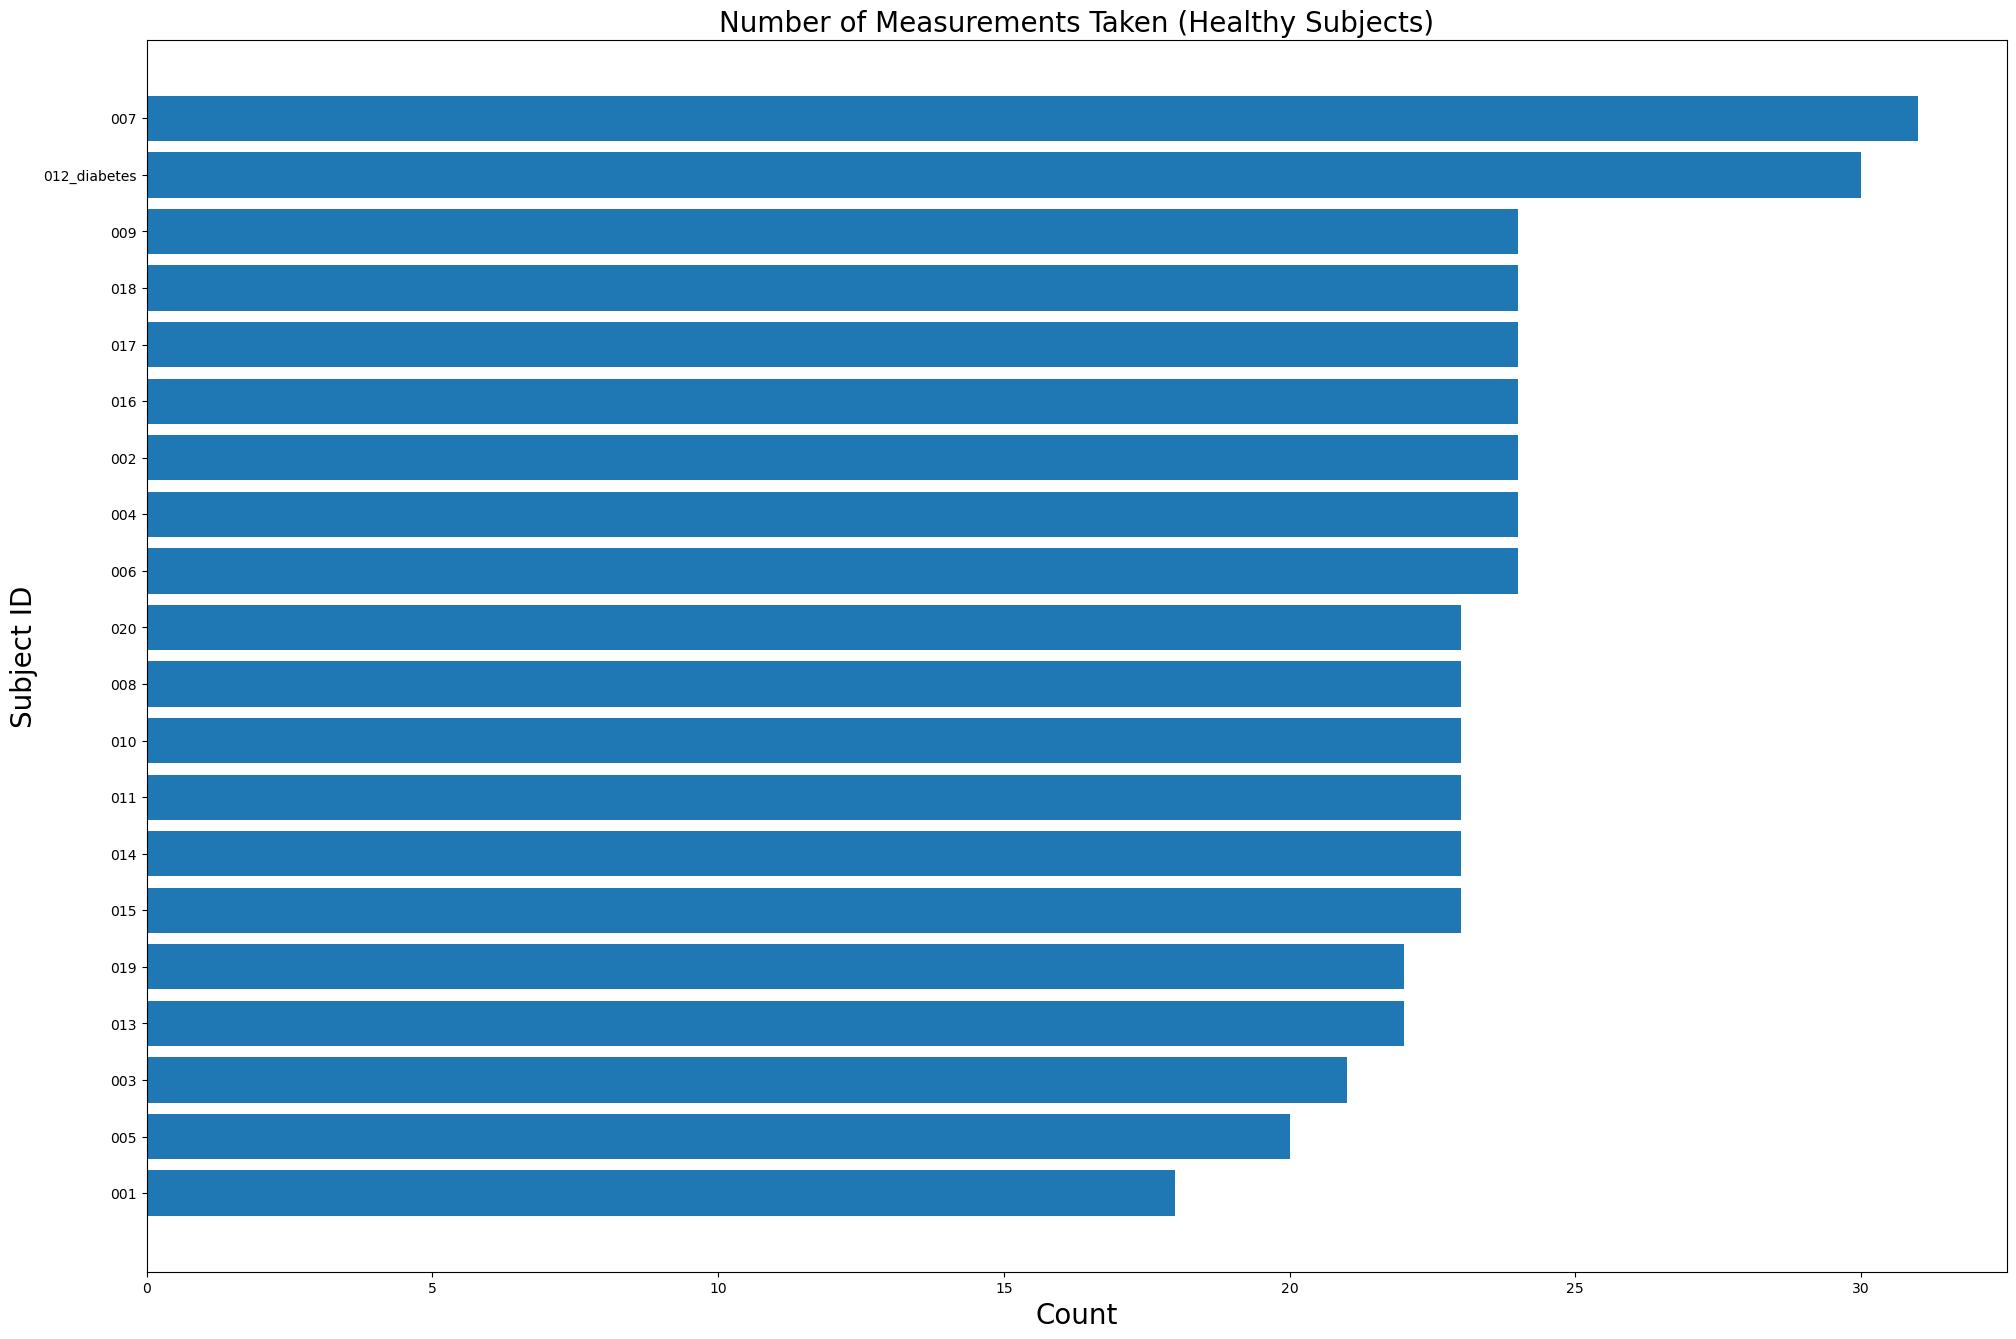

In [19]:
plot_subjects(healthy_glucose_count,"Count", "Number of Measurements Taken (Healthy Subjects)", "Count")

#### Insights

Once again it is clear that some subject (specifically the diabetes subset) were more thorough on thier data inputs than others.

I have come to the conclusion that I would like to create a model which classifies if a subject is diabetec or not...

I use different datasets to predicts:

1. Base Case: Glucose levels
2. Sensor data:





C:\Users\PC\anaconda3\envs\CA4016\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


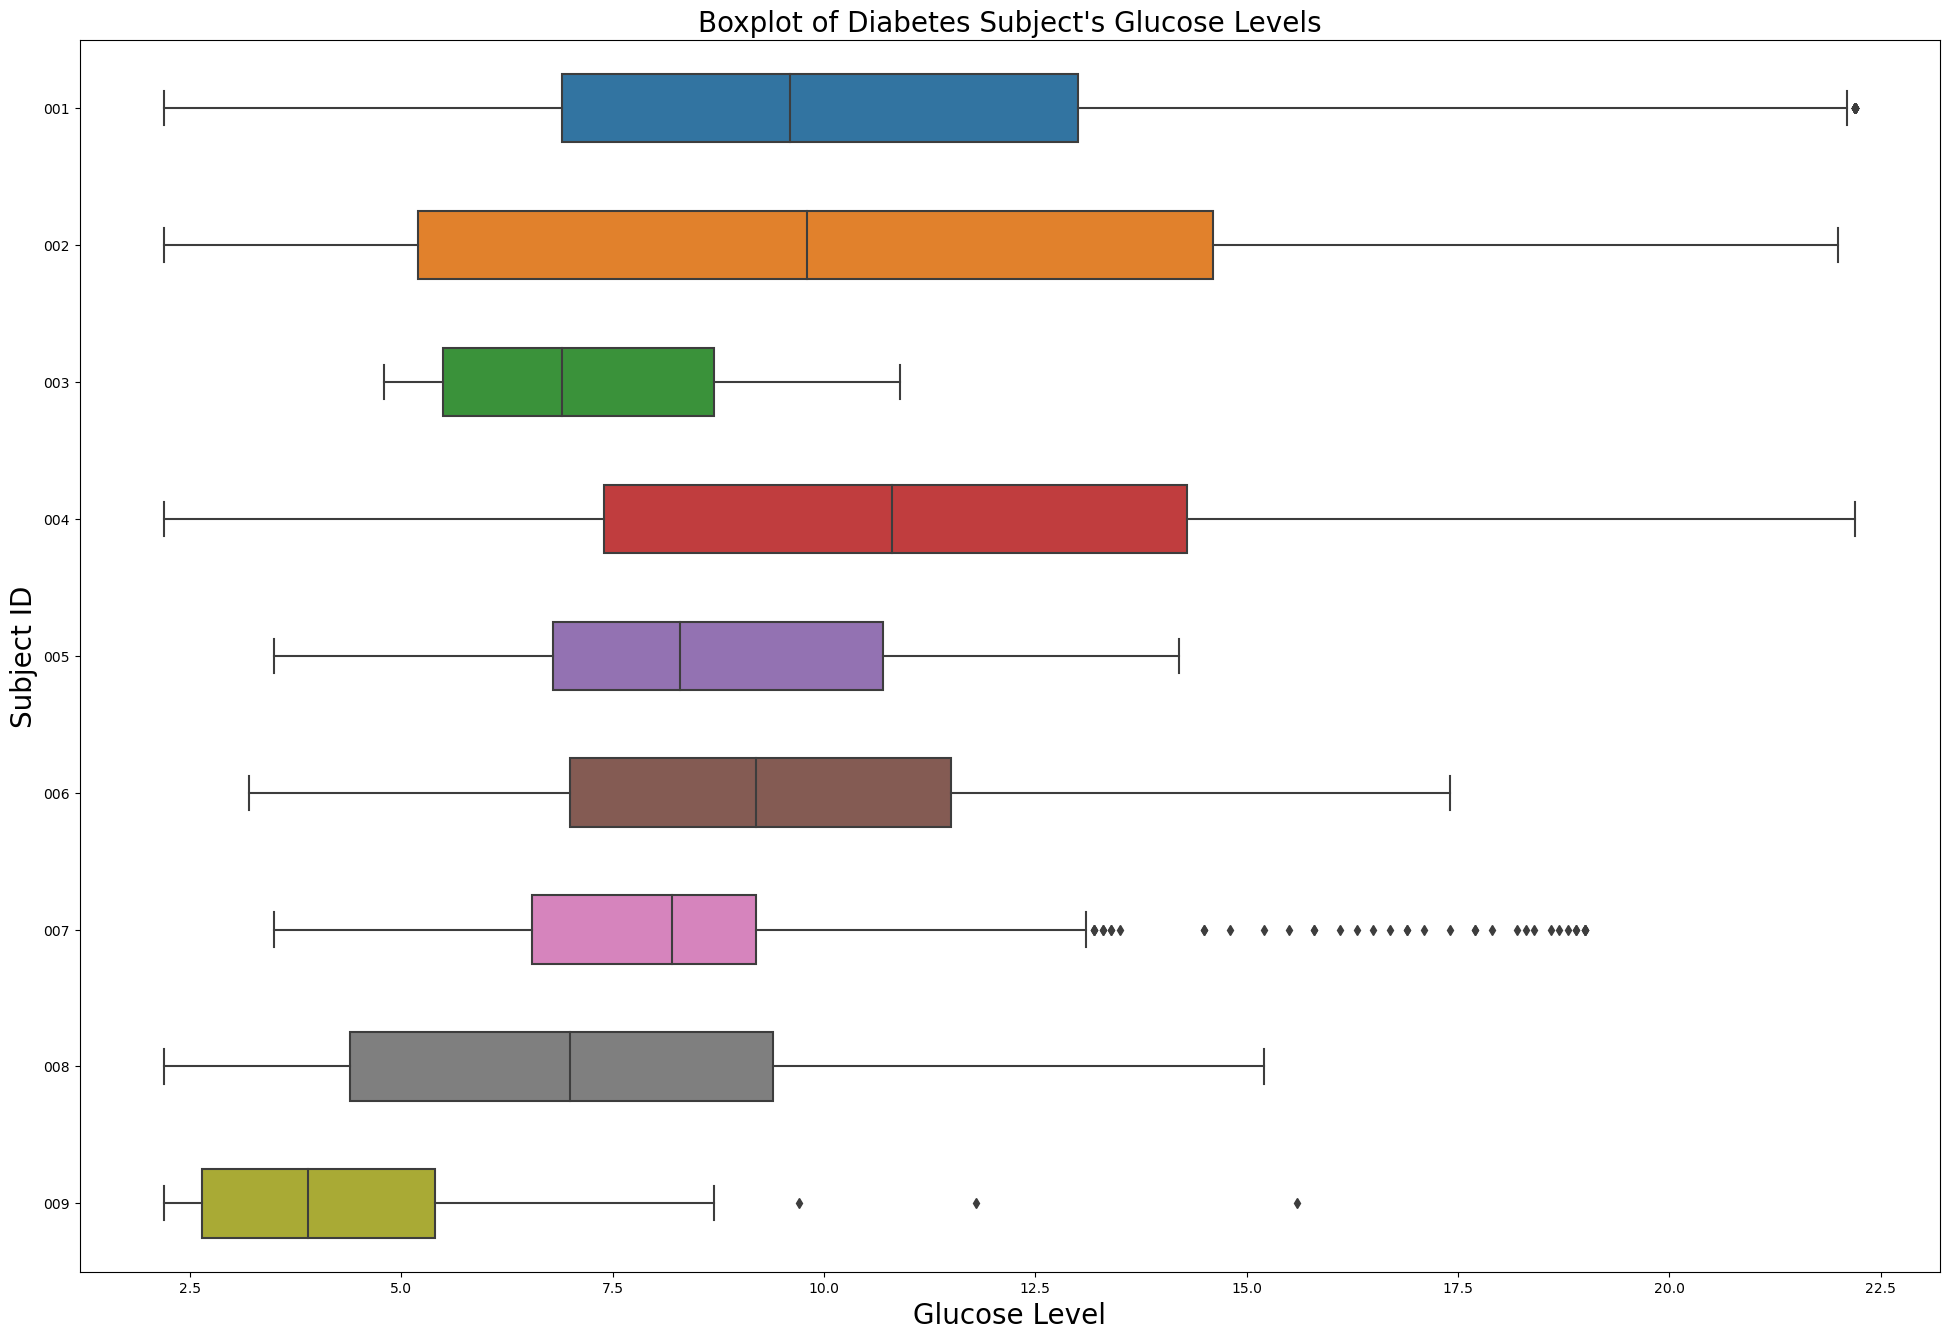

In [20]:
diabetes_glucose_data =  pd.DataFrame(glucose_data["diabetes_subset"])
plot_boxplot(diabetes_glucose_data, "Boxplot of Diabetes Subject's Glucose Levels")

C:\Users\PC\anaconda3\envs\CA4016\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


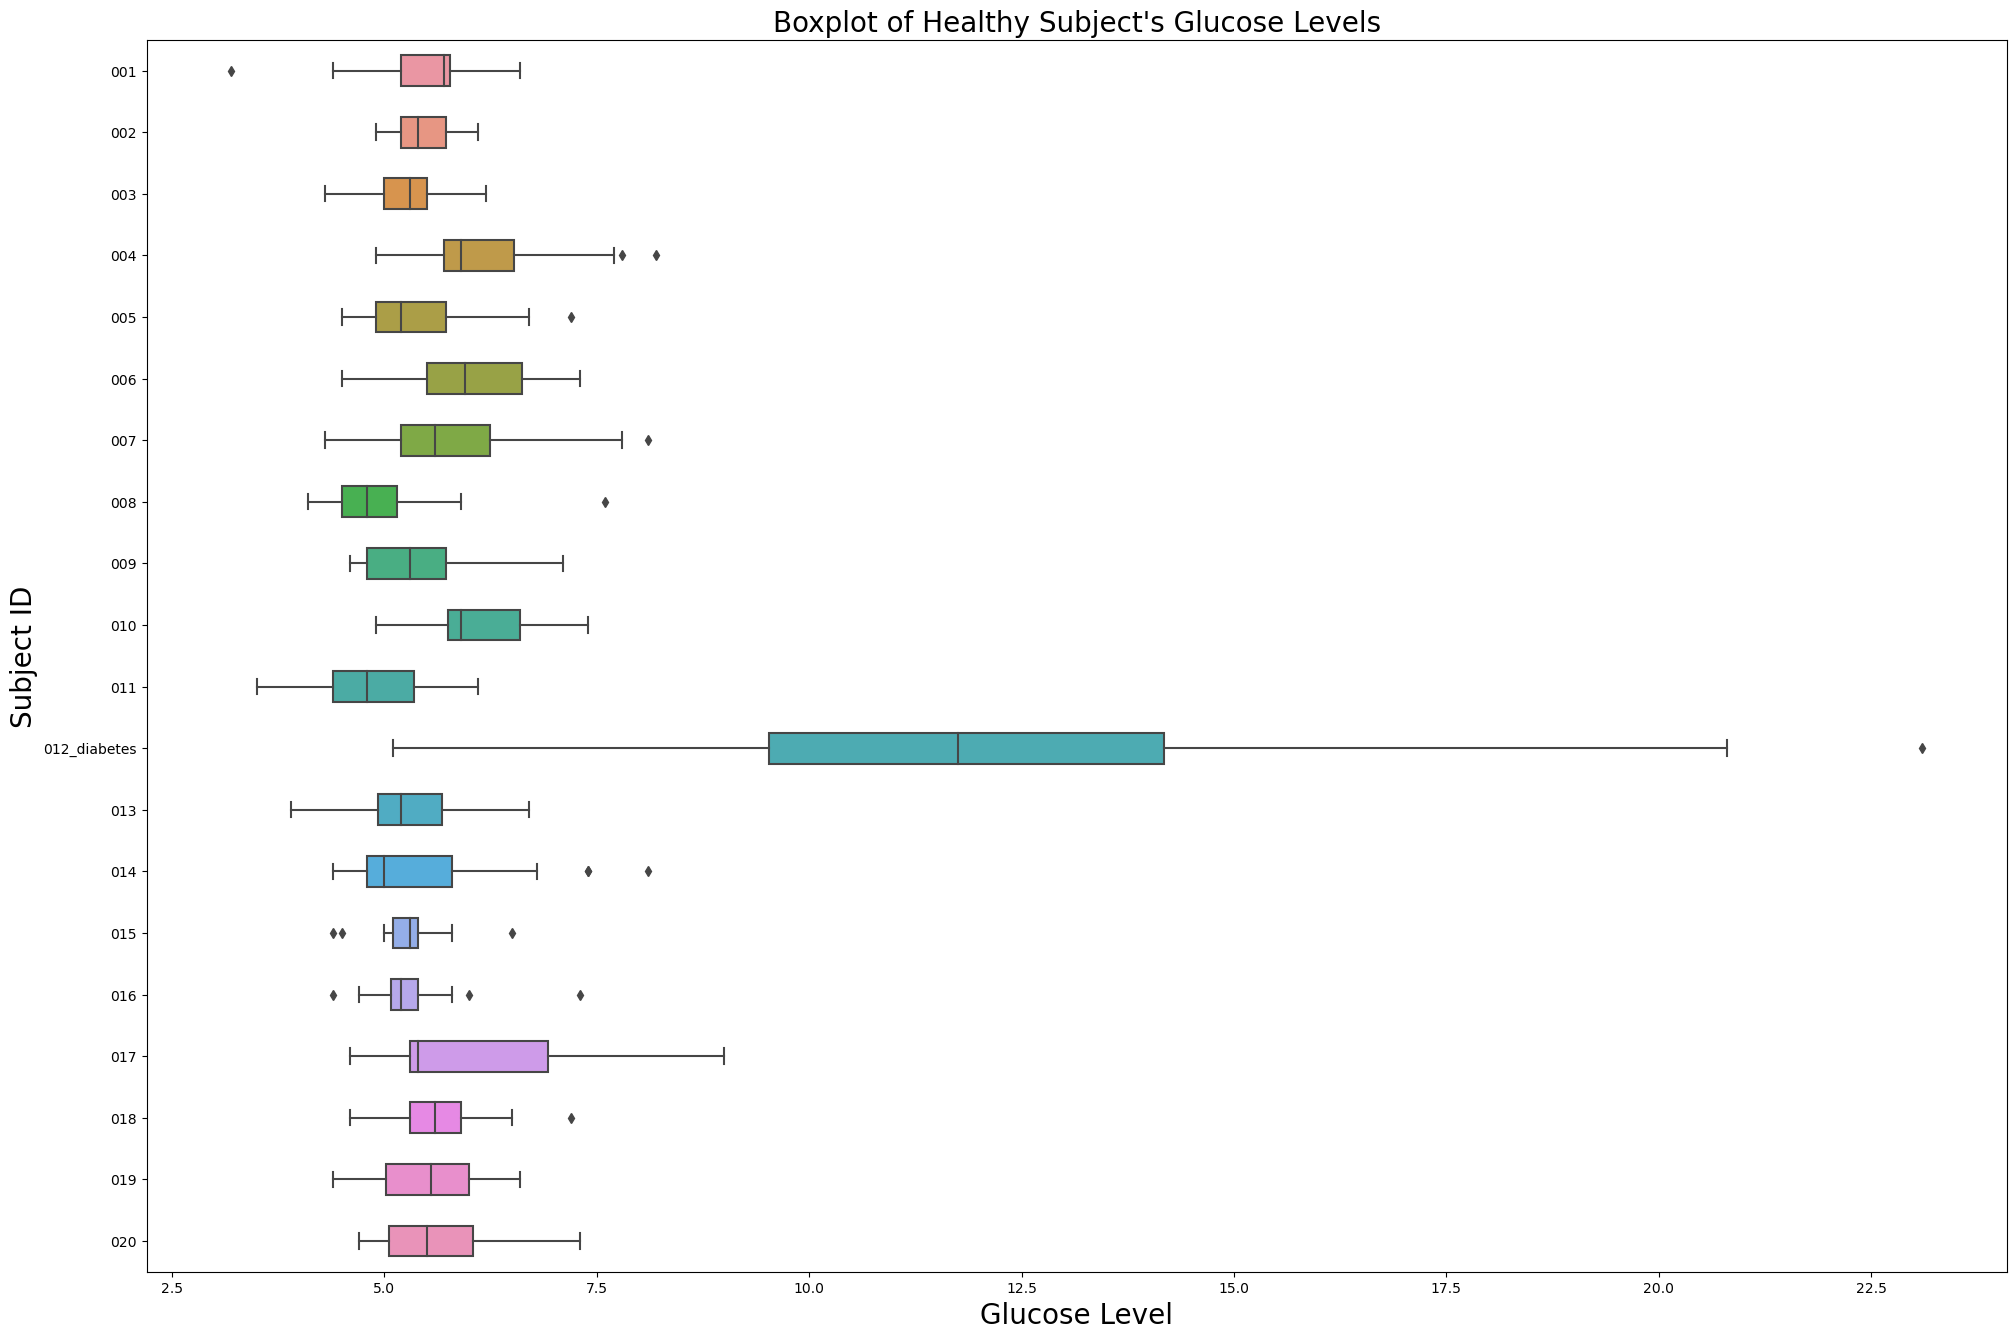

In [21]:
healthy_glucose_data =  pd.DataFrame(glucose_data["healthy_subset"])
plot_boxplot(healthy_glucose_data, "Boxplot of Healthy Subject's Glucose Levels")

C:\Users\PC\anaconda3\envs\CA4016\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


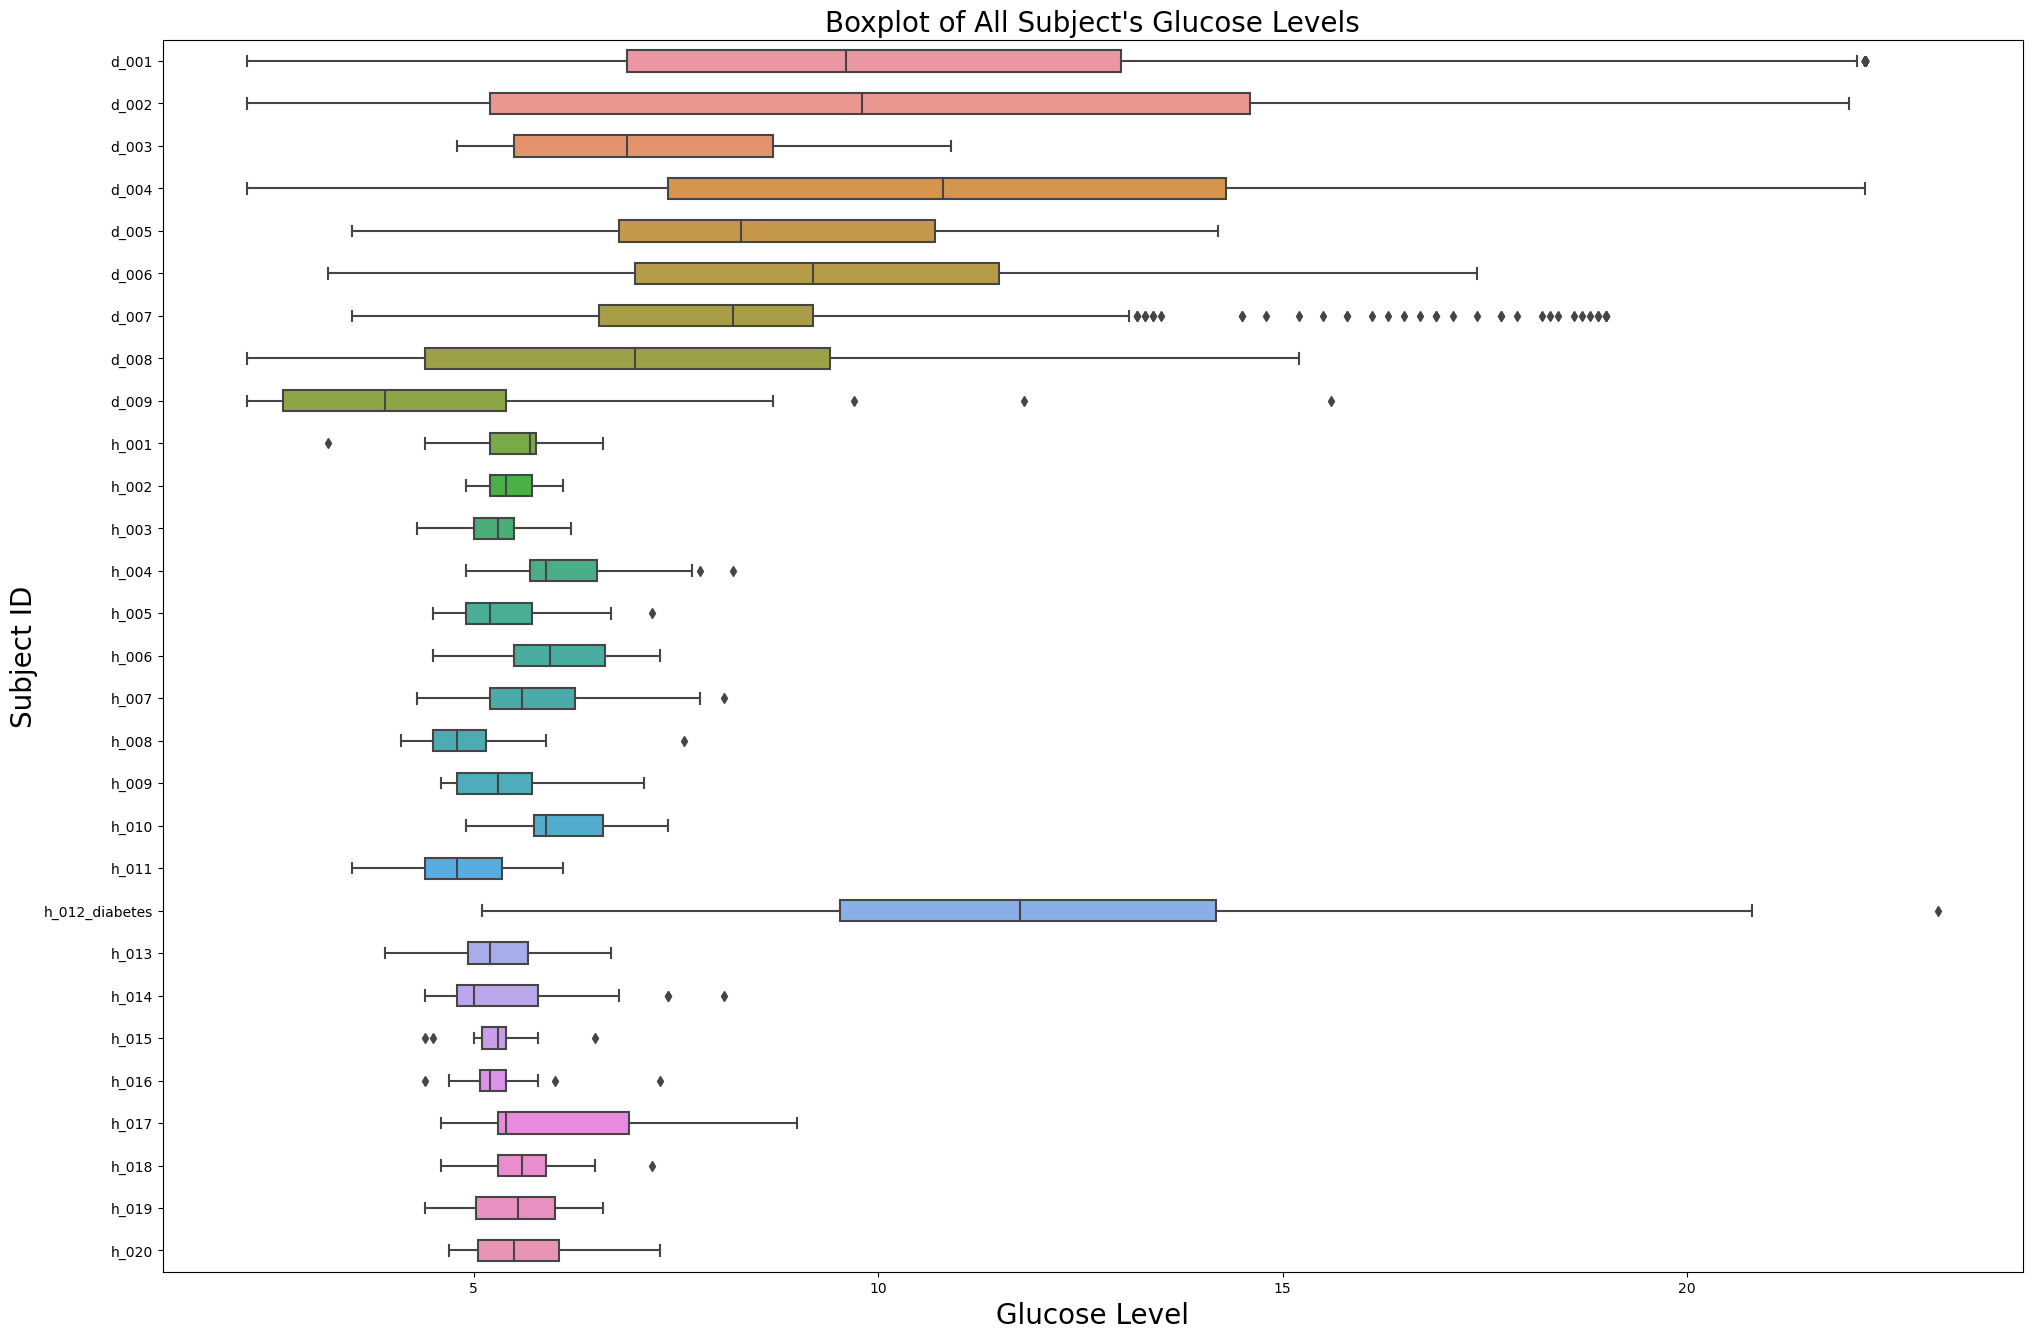

In [231]:
full_glucose_data =  pd.DataFrame(full_data)
plot_boxplot(full_glucose_data, "Boxplot of All Subject's Glucose Levels")

In [23]:
full_glucose_data.describe()

,d_001,d_002,d_003,d_004,d_005,d_006,d_007,d_008,d_009,h_001,...,h_010,h_011,h_012_diabetes,h_013,h_014,h_015,h_016,h_018,h_019,h_020
count,1438.000000,1071.000000,185.000000,984.000000,928.000000,1298.000000,1011.000000,1175.000000,131.000000,18.000000,...,23.000000,23.000000,30.000000,22.000000,23.000000,23.000000,24.000000,24.000000,22.000000,23.000000
mean,10.194089,10.160224,7.126486,11.197053,8.553125,9.437057,8.287735,7.183489,4.337405,5.394444,...,6.113043,4.856522,12.310000,5.372727,5.465217,5.317391,5.300000,5.633333,5.531818,5.626087
std,4.869156,5.557664,1.851351,4.984142,2.491290,3.193368,2.498861,3.192047,2.049665,0.734424,...,0.604757,0.696632,4.397519,0.702500,1.041681,0.430277,0.568751,0.573825,0.661446,0.729394
min,2.200000,2.200000,4.800000,2.200000,3.500000,3.200000,3.500000,2.200000,2.200000,3.200000,...,4.900000,3.500000,5.100000,3.900000,4.400000,4.400000,4.400000,4.600000,4.400000,4.700000
25%,6.900000,5.200000,5.500000,7.400000,6.800000,7.000000,6.550000,4.400000,2.650000,5.200000,...,5.750000,4.400000,9.525000,4.925000,4.800000,5.100000,5.075000,5.300000,5.025000,5.050000
50%,9.600000,9.800000,6.900000,10.800000,8.300000,9.200000,8.200000,7.000000,3.900000,5.700000,...,5.900000,4.800000,11.750000,5.200000,5.000000,5.300000,5.200000,5.600000,5.550000,5.500000
75%,13.000000,14.600000,8.700000,14.300000,10.700000,11.500000,9.200000,9.400000,5.400000,5.775000,...,6.600000,5.350000,14.175000,5.675000,5.800000,5.400000,5.400000,5.900000,6.000000,6.050000
max,22.200000,22.000000,10.900000,22.200000,14.200000,17.400000,19.000000,15.200000,15.600000,6.600000,...,7.400000,6.100000,23.100000,6.700000,8.100000,6.500000,7.300000,7.200000,6.600000,7.300000


In [24]:
diabetes_five_top_picks = pick_top_subjects(diabetes_calories, diabetes_glucose_count, 5)

In [25]:
healthy_five_top_picks = pick_top_subjects(healthy_calories, healthy_glucose_count, 5)

In [26]:
copy_files(diabetes_five_top_picks, healthy_five_top_picks)

No such file or directory: ../data/D1NAMO/healthy_subset/007/sensor_data/2014_10_01-07_50_37/2014_10_01-07_50_37_Summary.csv
